# Data Sorting, Averaging, and Plotting Script

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

from atmodeller import debug_logger, debug_file_logger
from atmodeller.plot import Plotter, AxesSpec

logger = debug_logger()

In [2]:
#Import plotting tools:

import matplotlib
import matplotlib.pyplot as plt
plt.rc("savefig", dpi=300)
plt.rc('figure', dpi=300)
plt.rc('text', usetex=True)
plt.rc('font', size=15)
plt.rc('xtick', direction='in') 
plt.rc('ytick', direction='in')
plt.rc('xtick.major', pad=5) 
plt.rc('xtick.minor', pad=5)
plt.rc('ytick.major', pad=5) 
plt.rc('ytick.minor', pad=5)
plt.rc('lines', dotted_pattern = [0.5, 1.1])

font={'weight':'bold',
     'size': 15}
matplotlib.rc('font', **font)
plt.rcParams["figure.figsize"] = (7,5)

## Read in data file using Plotter 

In [3]:
surface_temperature = 1800
trappist1e_with_sols_path = Path(f"DataFiles/trappist1e_{surface_temperature}K_with_sols_10000its")

plotter_with_sols = Plotter.read_pickle(trappist1e_with_sols_path.with_suffix('.pkl'))
plotter_with_sols.dataframes['atmosphere']

trappist1e_no_sols_path = Path(f"DataFiles/trappist1e_{surface_temperature}K_no_sols_10000its_batch1")

plotter_no_sols = Plotter.read_pickle(trappist1e_no_sols_path.with_suffix('.pkl'))

[09:52:51 - atmodeller.output              - INFO     ] - Output: Reading data from DataFiles/trappist1e_1800K_with_sols_10000its.pkl
[09:52:52 - atmodeller.plot                - INFO     ] - Found data for dict_keys(['H2O', 'H2', 'O2', 'CO', 'CO2', 'CH4', 'N2', 'NH3', 'S2', 'H2S', 'SO2', 'SO', 'Cl2', 'H_totals', 'N_totals', 'S_totals', 'C_totals', 'O_totals', 'Cl_totals', 'atmosphere', 'constraints', 'planet', 'residual', 'solution', 'extra'])
[09:52:54 - atmodeller.output              - INFO     ] - Output: Reading data from DataFiles/trappist1e_1800K_no_sols_10000its_batch1.pkl
[09:52:55 - atmodeller.plot                - INFO     ] - Found data for dict_keys(['H2O', 'H2', 'O2', 'CO', 'CO2', 'CH4', 'N2', 'NH3', 'S2', 'H2S', 'SO2', 'SO', 'Cl2', 'H_totals', 'Cl_totals', 'S_totals', 'N_totals', 'O_totals', 'C_totals', 'atmosphere', 'constraints', 'planet', 'residual', 'solution', 'extra'])


## Sorting Function

In [4]:
def SortData(datafile, sheettosort, columntosort):
    species=['H2', 'H2O', 'O2', 'CO', 'CO2', 'CH4', 'N2', 'NH3', 'S2', 'SO', 'H2S', 'SO2', 'atmosphere']
    out: dict[str, pd.DataFrame] = {}
    for i in species:
        df_species = datafile.dataframes[i]
        df_species[columntosort]=datafile.dataframes[sheettosort][columntosort]
        df_species = df_species.sort_values(by=[columntosort])
        out[i]=(df_species)
    return out

T1e_with_sols_sort = SortData(plotter_with_sols, 'extra', 'fO2_shift')
T1e_no_sols_sort = SortData(plotter_no_sols, 'extra', 'fO2_shift')



## Bin and Average the Data, Calculate Standard Deviation

In [5]:
def AverageData(datafile_sorted, n):
    species=['H2', 'H2O', 'O2', 'CO', 'CO2', 'CH4', 'N2', 'NH3', 'S2', 'SO', 'H2S', 'SO2', 'atmosphere']
    output: dict[str, pd.DataFrame] = {}
    for i in species:
        out = pd.DataFrame()
        for j in datafile_sorted[i].columns:
            data_reshape = np.array(datafile_sorted[i][j]).reshape(-1,n) #First reshape each column into a set of arrays with length n
            data_avg = np.average(data_reshape, axis=1) #Then average over each of these arrays to create averaged, binned data
            data_std = np.std(data_avg) #Compute standard deviation (1 sigma) of this averaged data 
            out[j]=data_avg
            out[str(j)+'_std']=data_std
        output[i]=out
    return(output)

T1e_with_sols_sort_avg = AverageData(T1e_with_sols_sort, 50)
T1e_no_sols_sort_avg = AverageData(T1e_no_sols_sort, 50)

In [6]:
print(T1e_with_sols_sort_avg['H2O']['atmosphere_pressure']/T1e_with_sols_sort_avg['atmosphere']['pressure'])
print(T1e_no_sols_sort_avg['H2O']['atmosphere_pressure']/T1e_no_sols_sort_avg['atmosphere']['pressure'])

0      0.000146
1      0.000190
2      0.000183
3      0.000151
4      0.000193
         ...   
195    0.002923
196    0.003268
197    0.003033
198    0.003387
199    0.003657
Length: 200, dtype: float64
0      0.000386
1      0.000312
2      0.000421
3      0.000414
4      0.000412
         ...   
195    0.515398
196    0.505055
197    0.527763
198    0.501667
199    0.511961
Length: 200, dtype: float64


## Plot

In [7]:
species=['H2', 'H2O', 'CO', 'CO2', 'CH4', 'N2', 'NH3', 'H2S', 'SO2', 'S2', 'SO', 'atmosphere']
colors=['navy', 'dodgerblue', 'orange', 'orangered', 'deeppink', 'violet', 'purple', 'lawngreen', 'forestgreen', 'turquoise', 'teal', 'gray']


def Plot_AvgData(file, x_axis, y_axis, species_set, colors_set, y_min, y_max, yscale):
    fig, ax = plt.subplots()
    for i,j in zip(species_set, colors_set):
        plt.plot(file[i][x_axis], file[i][y_axis], color=j)
        plt.fill_between(file[i][x_axis], file[i][y_axis] - file[i][str(y_axis)+'_std'], file[i][y_axis] + file[i][str(y_axis)+'_std'], 
                         color=j, alpha=0.2, label=str(i))
        
    plt.xlabel(str(x_axis))
    plt.ylabel(str(y_axis))
    plt.yscale(yscale)
    plt.ylim(y_min, y_max)
    plt.legend(fontsize=10)
    plt.show()


def Plot_AvgData_VMR(file, x_axis, y_axis, species_set, colors_set, y_min, y_max, yscale):
    fig, ax = plt.subplots()
    for i,j in zip(species_set, colors_set):
        plt.plot(file[i][x_axis], file[i][y_axis]/file['atmosphere']['pressure'], color=j)
        plt.fill_between(file[i][x_axis], (file[i][y_axis]/file['atmosphere']['pressure']) - (file[i][str(y_axis)+'_std']/file['atmosphere']['pressure_std']), (file[i][y_axis]/file['atmosphere']['pressure']) + (file[i][str(y_axis)+'_std']/file['atmosphere']['pressure_std']), 
                         color=j, alpha=0.2, label=str(i))
        
    plt.xlabel(str(x_axis))
    plt.ylabel(str(y_axis))
    plt.yscale(yscale)
    plt.ylim(y_min, y_max)
    plt.legend(fontsize=10)
    plt.show()

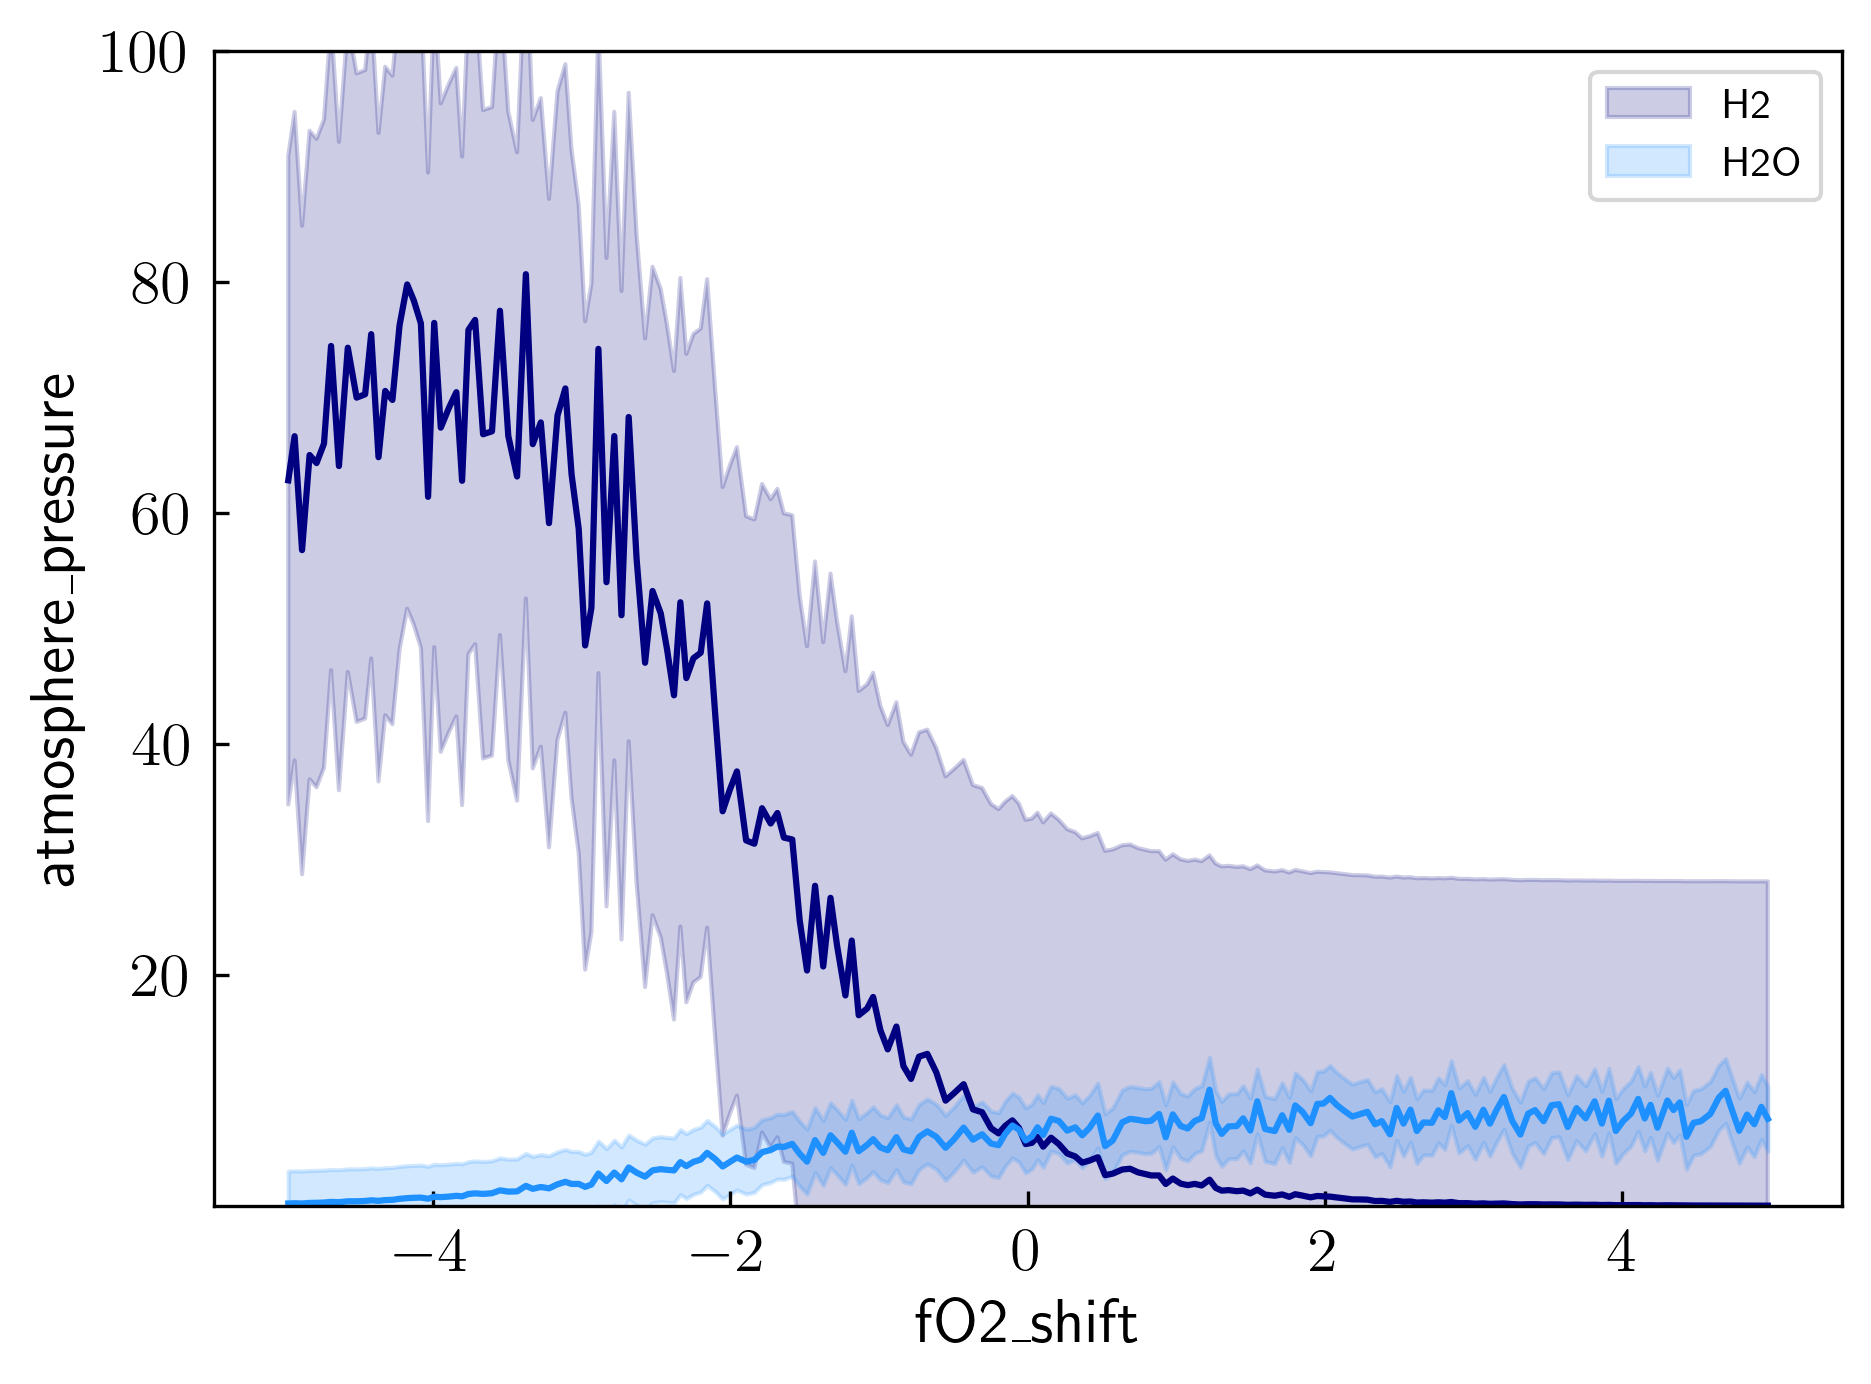

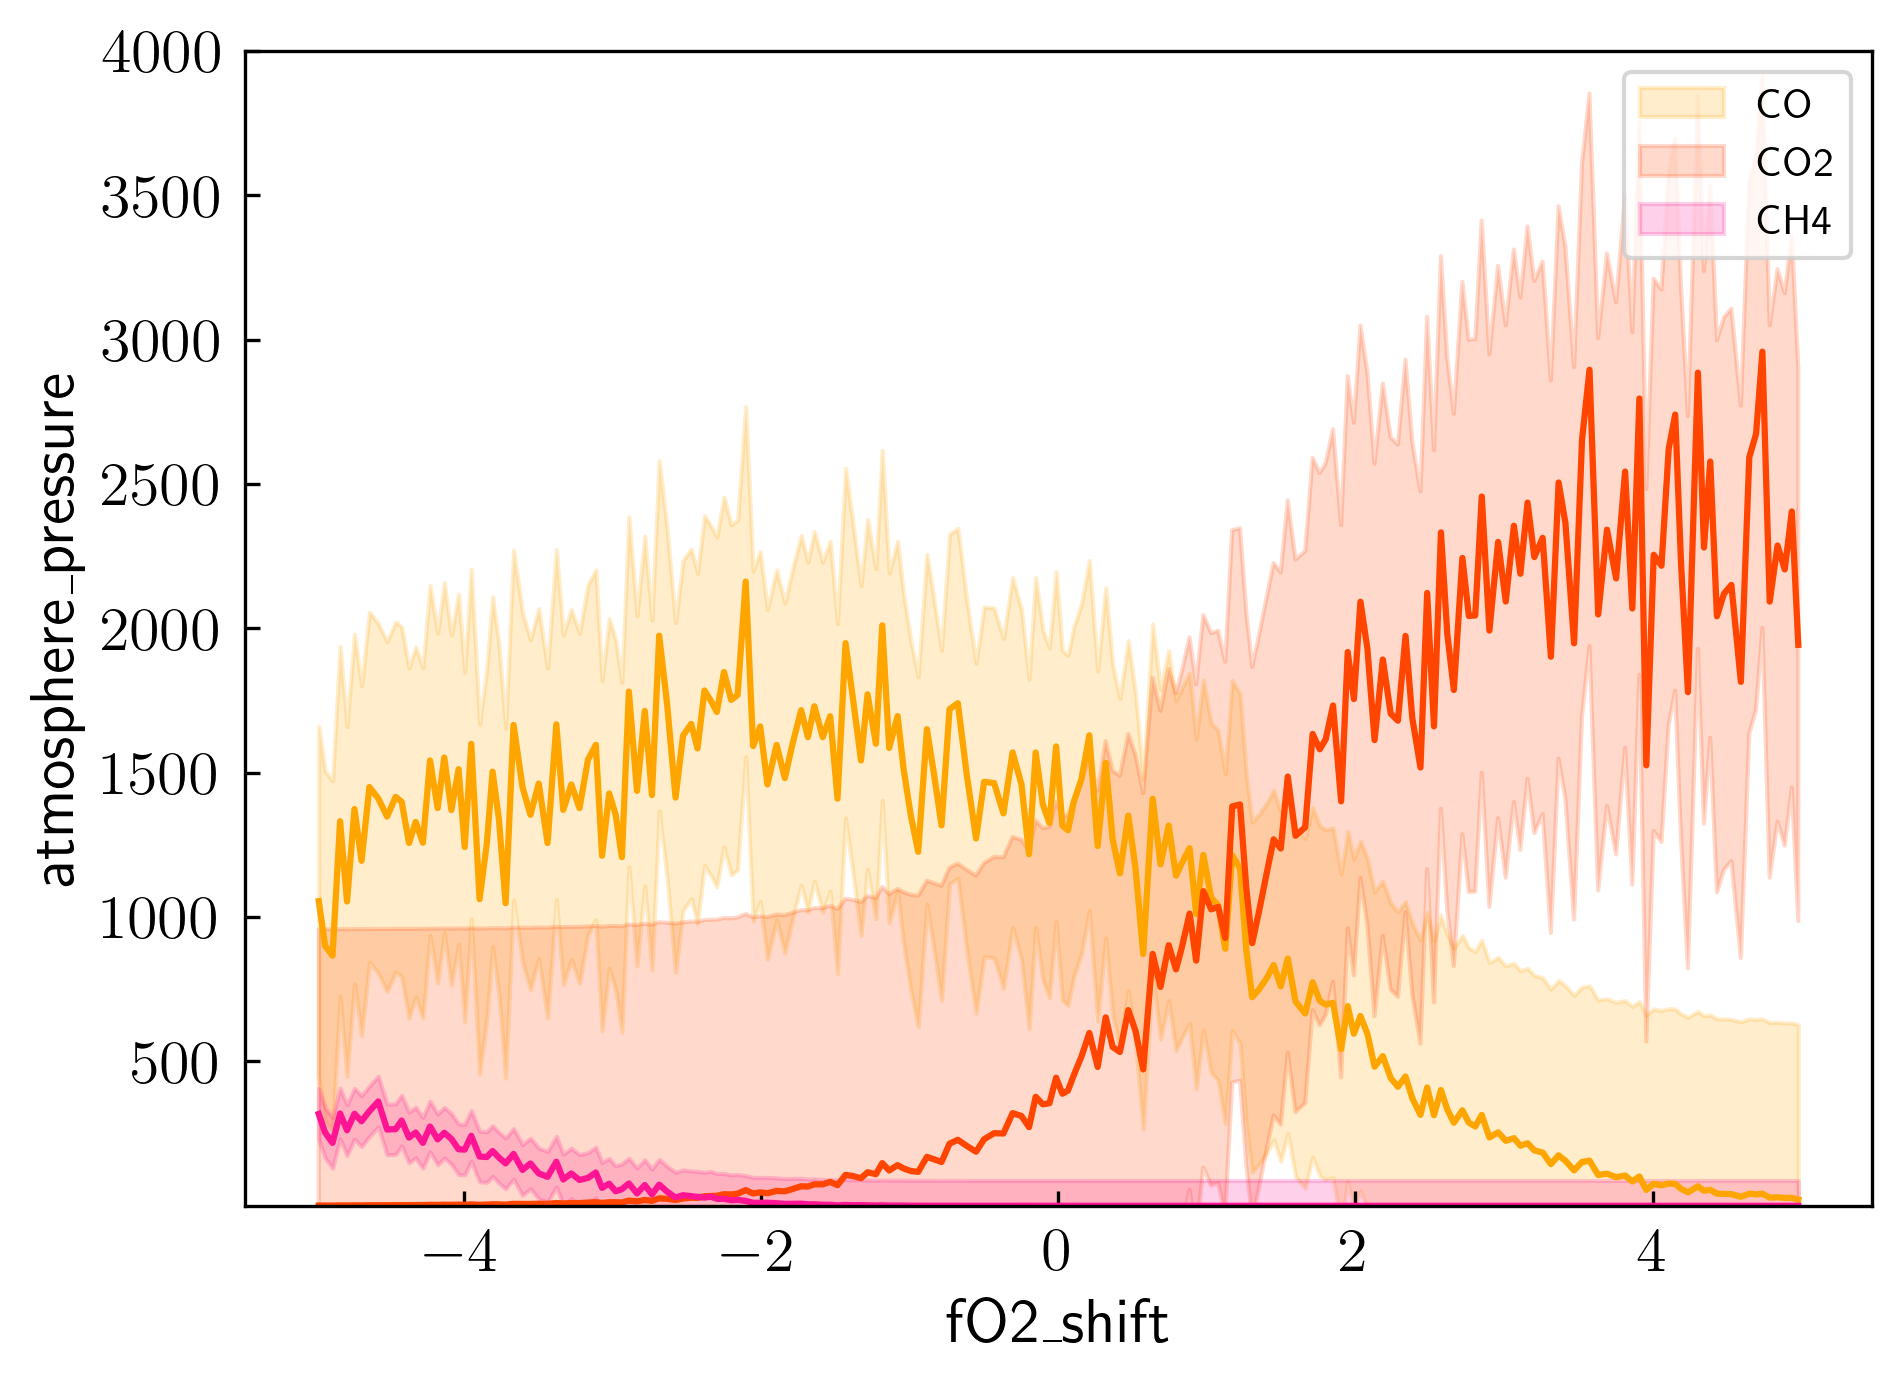

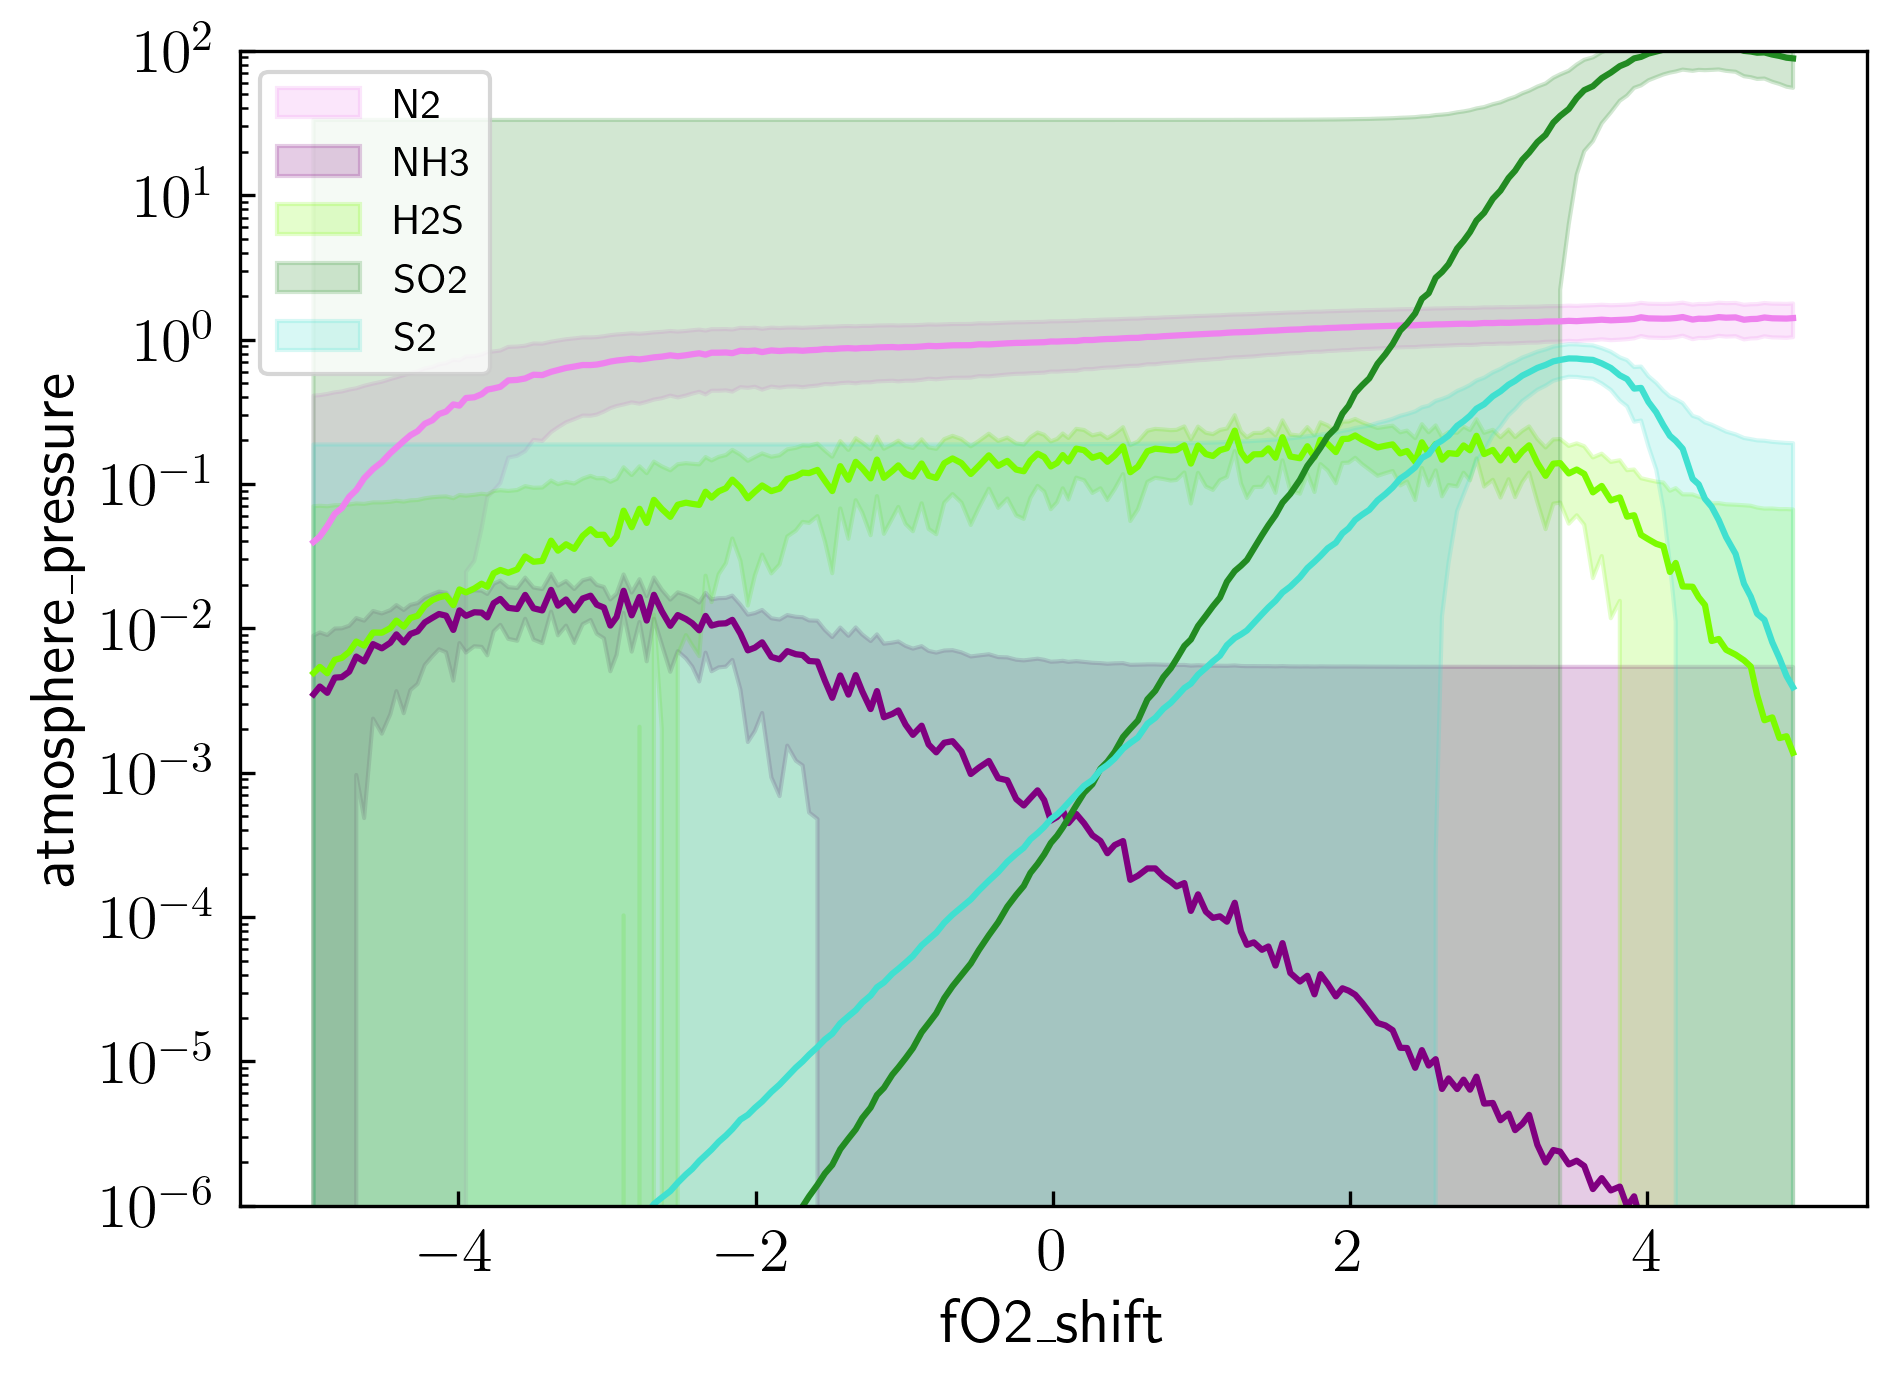

In [8]:
Plot_AvgData(T1e_with_sols_sort_avg, 'fO2_shift', 'atmosphere_pressure', species[0:2], colors[0:2], 1e-2, 100, 'linear')

Plot_AvgData(T1e_with_sols_sort_avg, 'fO2_shift', 'atmosphere_pressure', species[2:5], colors[2:5], 1e-2, 4000, 'linear')

Plot_AvgData(T1e_with_sols_sort_avg, 'fO2_shift', 'atmosphere_pressure', species[5:10], colors[5:10], 1e-6, 100, 'log')


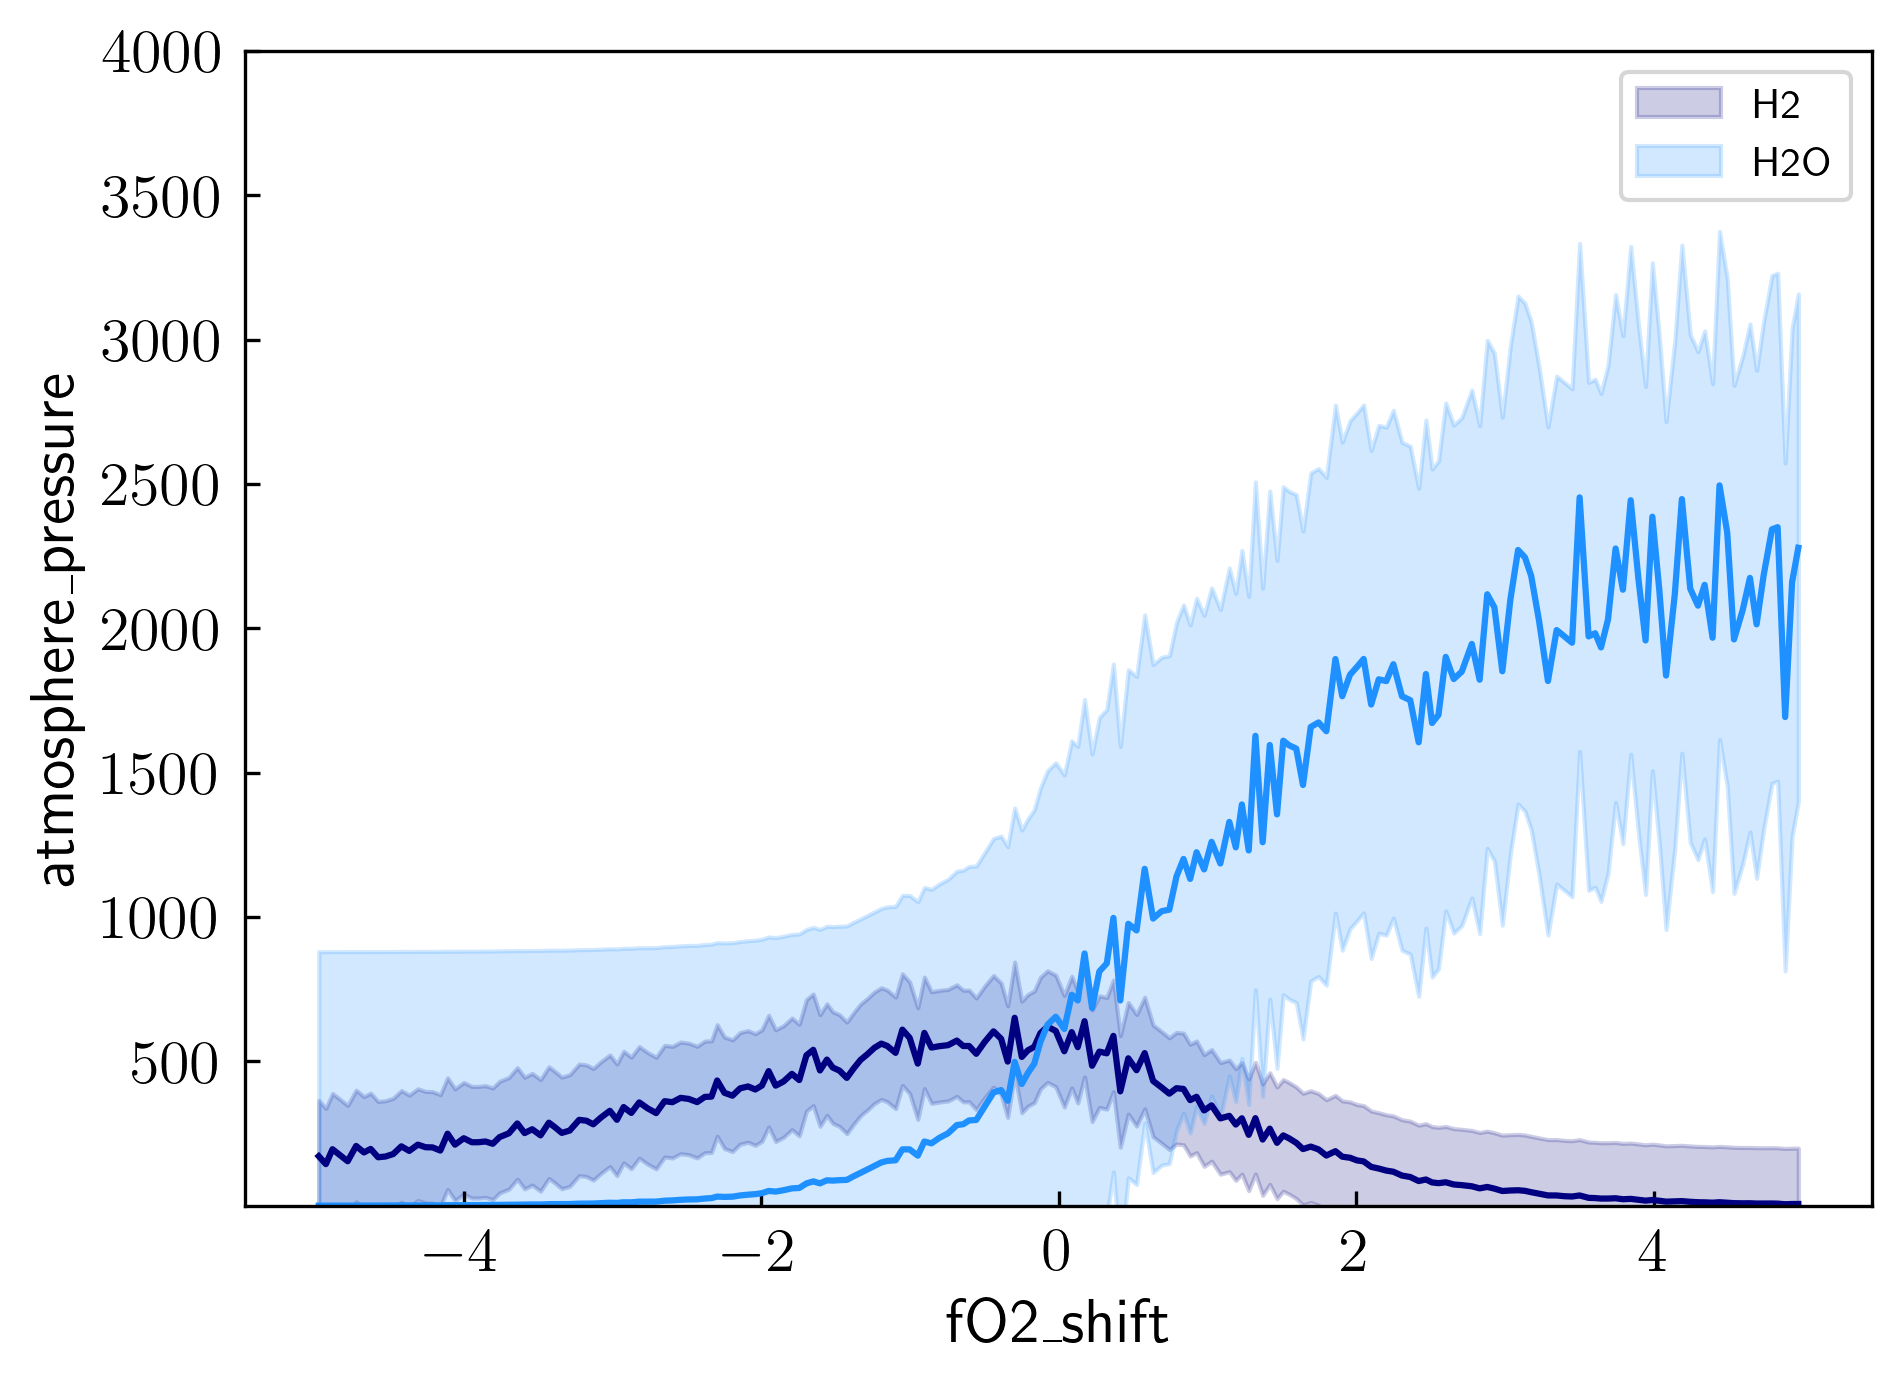

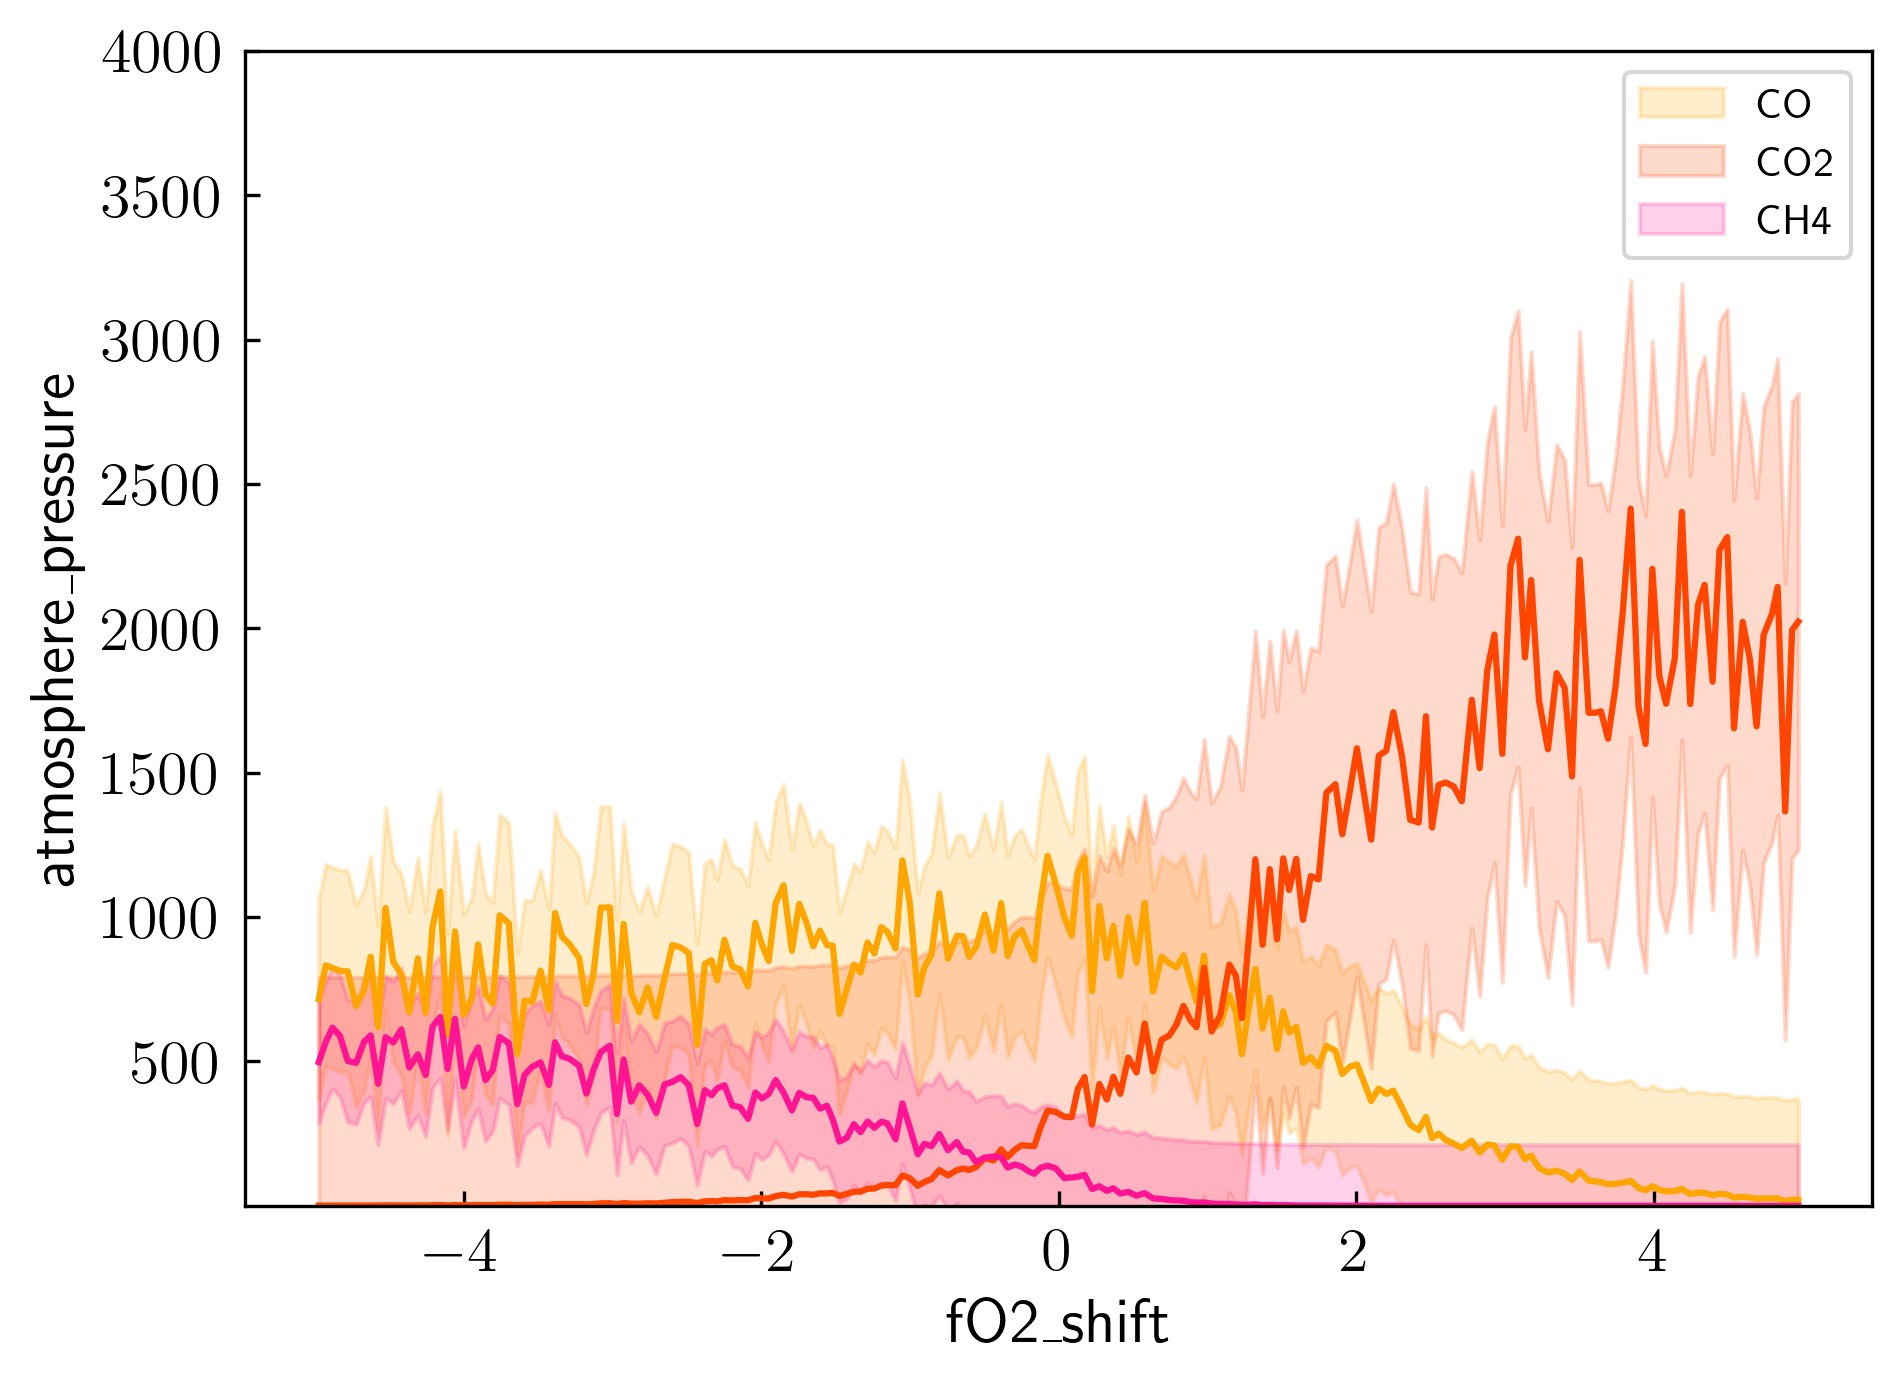

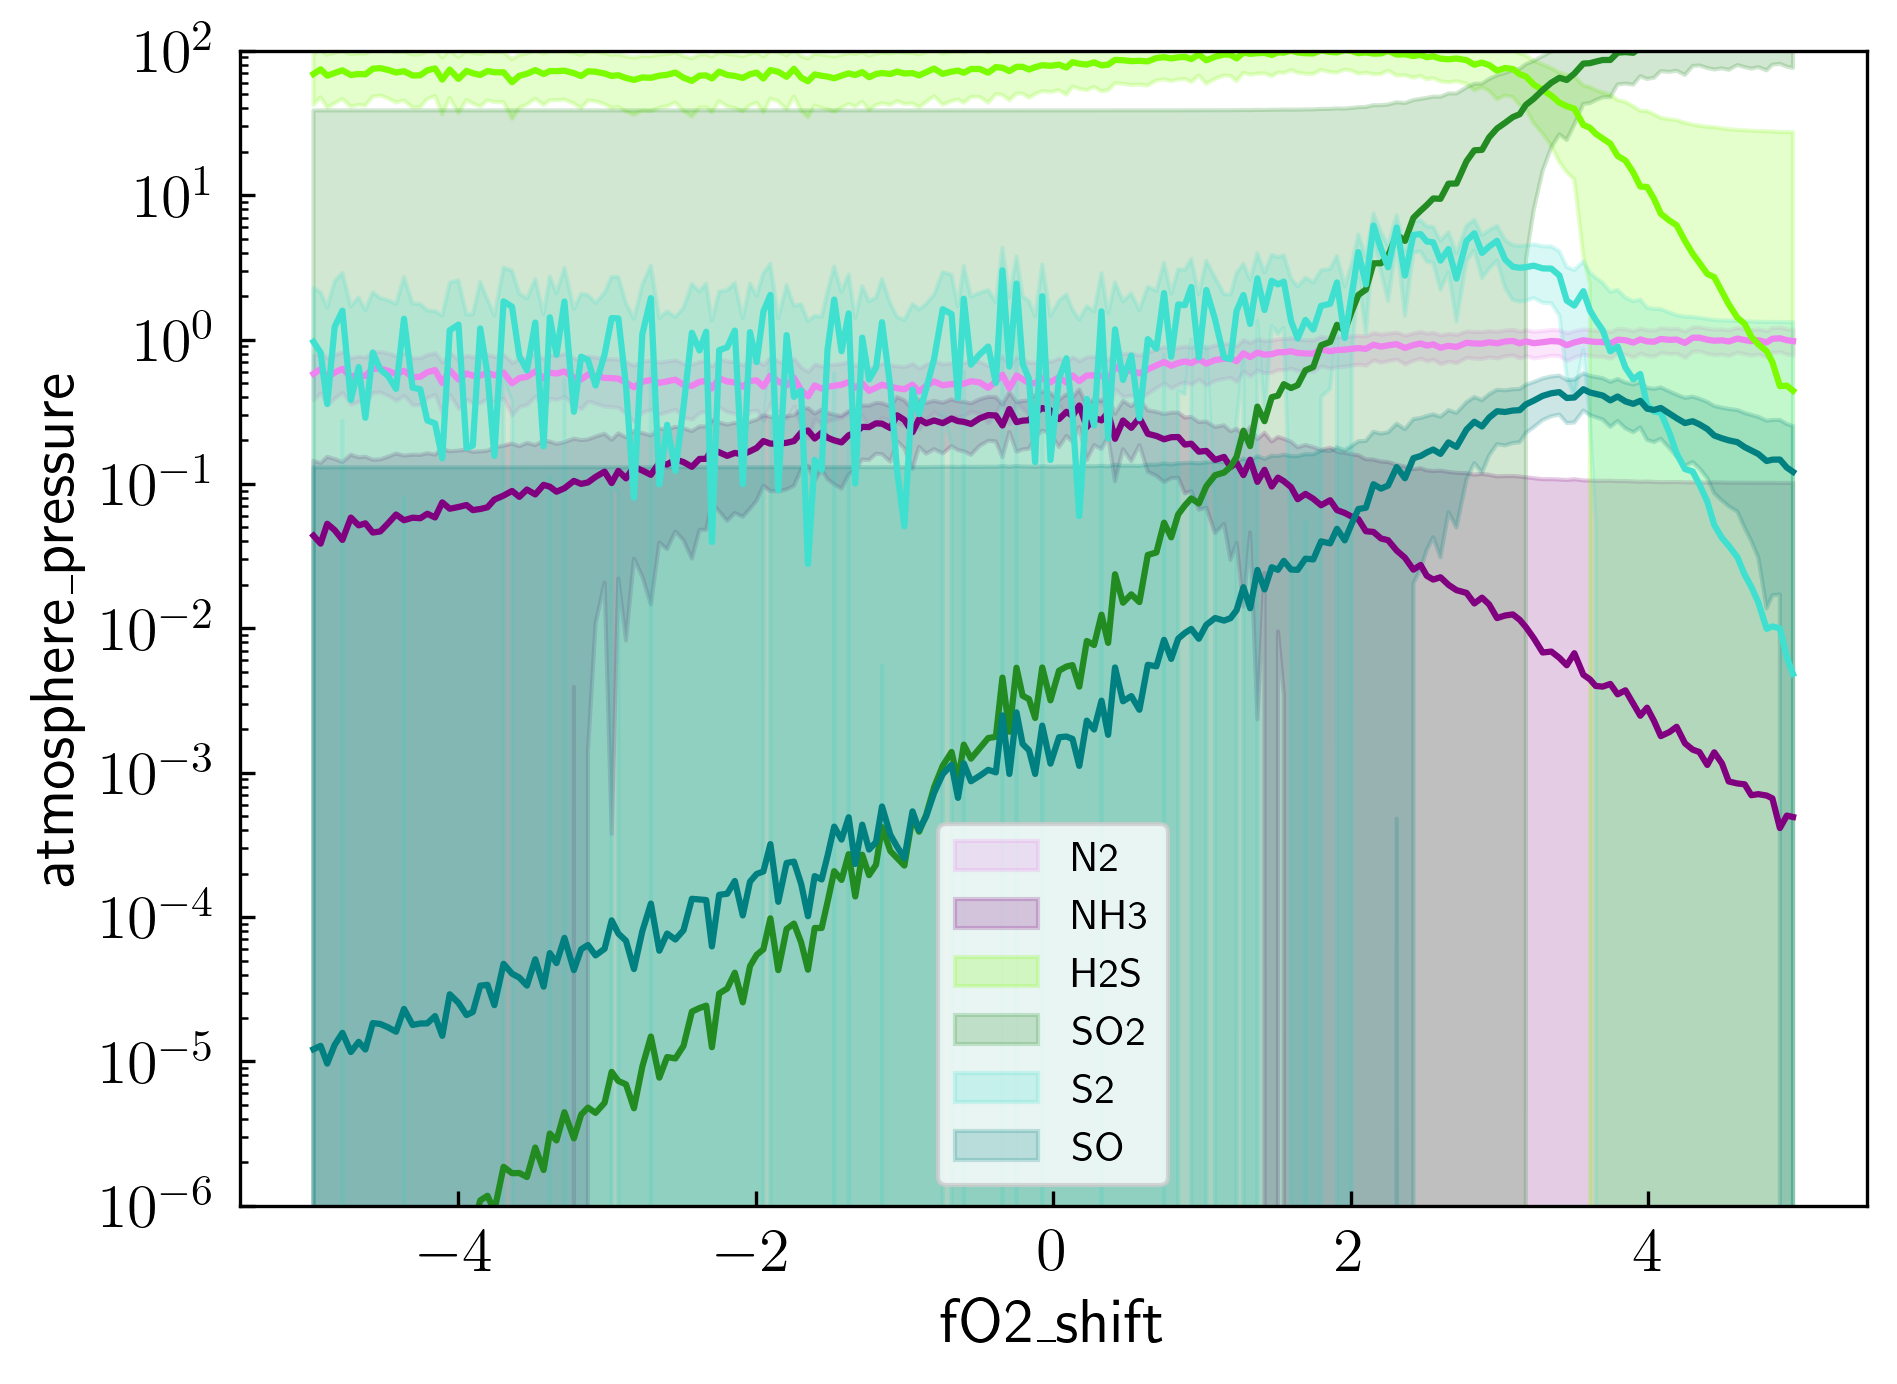

In [16]:
Plot_AvgData(T1e_no_sols_sort_avg, 'fO2_shift', 'atmosphere_pressure', species[0:2], colors[0:2], 1e-2, 4000, 'linear')

Plot_AvgData(T1e_no_sols_sort_avg, 'fO2_shift', 'atmosphere_pressure', species[2:5], colors[2:5], 1e-2, 4000, 'linear')

Plot_AvgData(T1e_no_sols_sort_avg, 'fO2_shift', 'atmosphere_pressure', species[5:11], colors[5:11], 1e-6, 100, 'log')

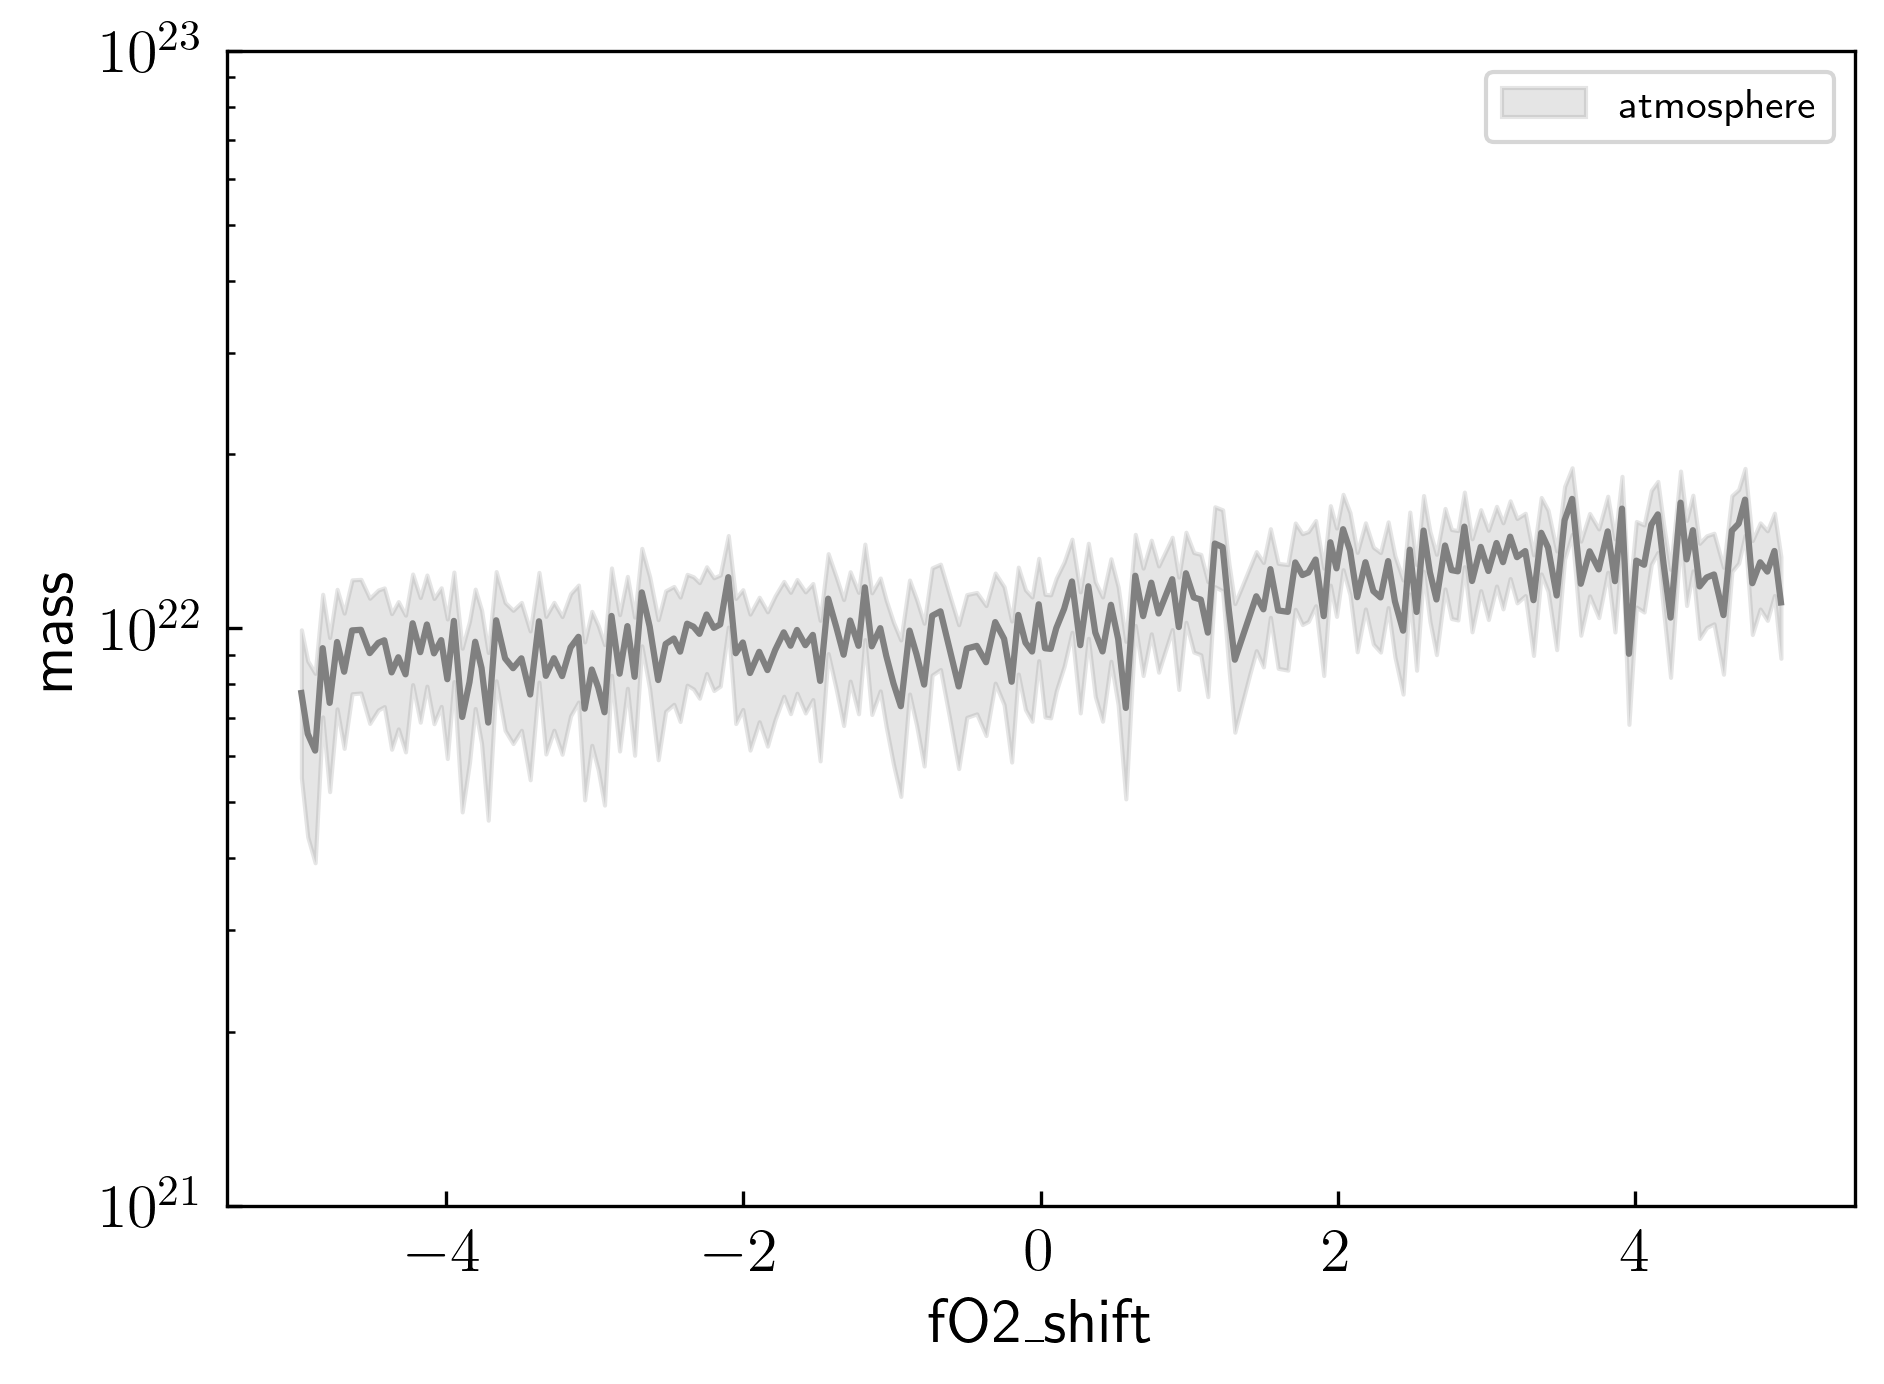

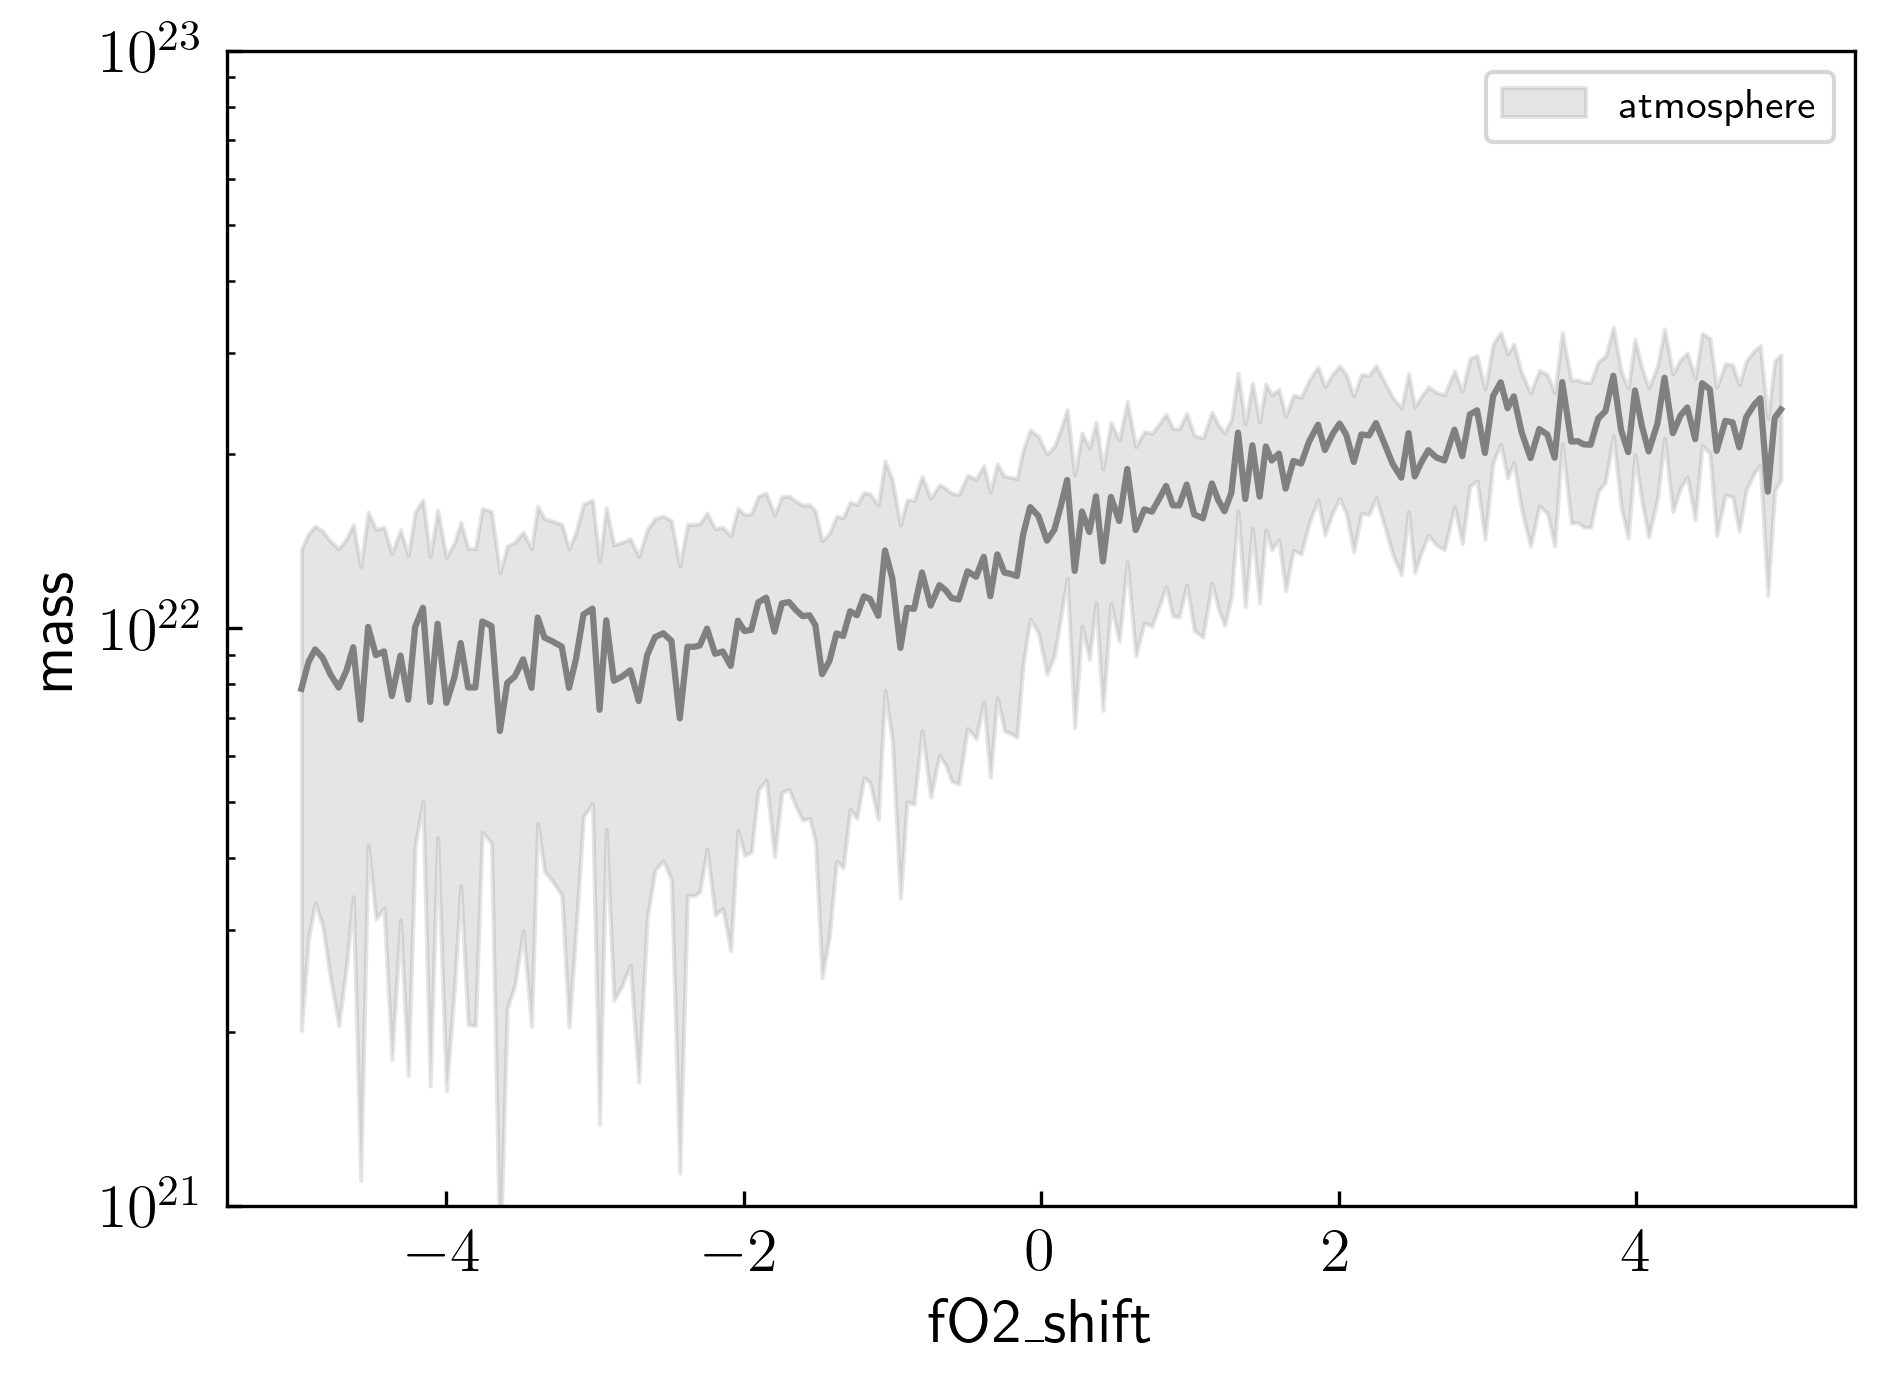

In [18]:
Plot_AvgData(T1e_with_sols_sort_avg, 'fO2_shift', 'mass', species[11:], colors[11:], 1e21, 1e23, 'log')
Plot_AvgData(T1e_no_sols_sort_avg, 'fO2_shift', 'mass', species[11:], colors[11:], 1e21, 1e23, 'log')

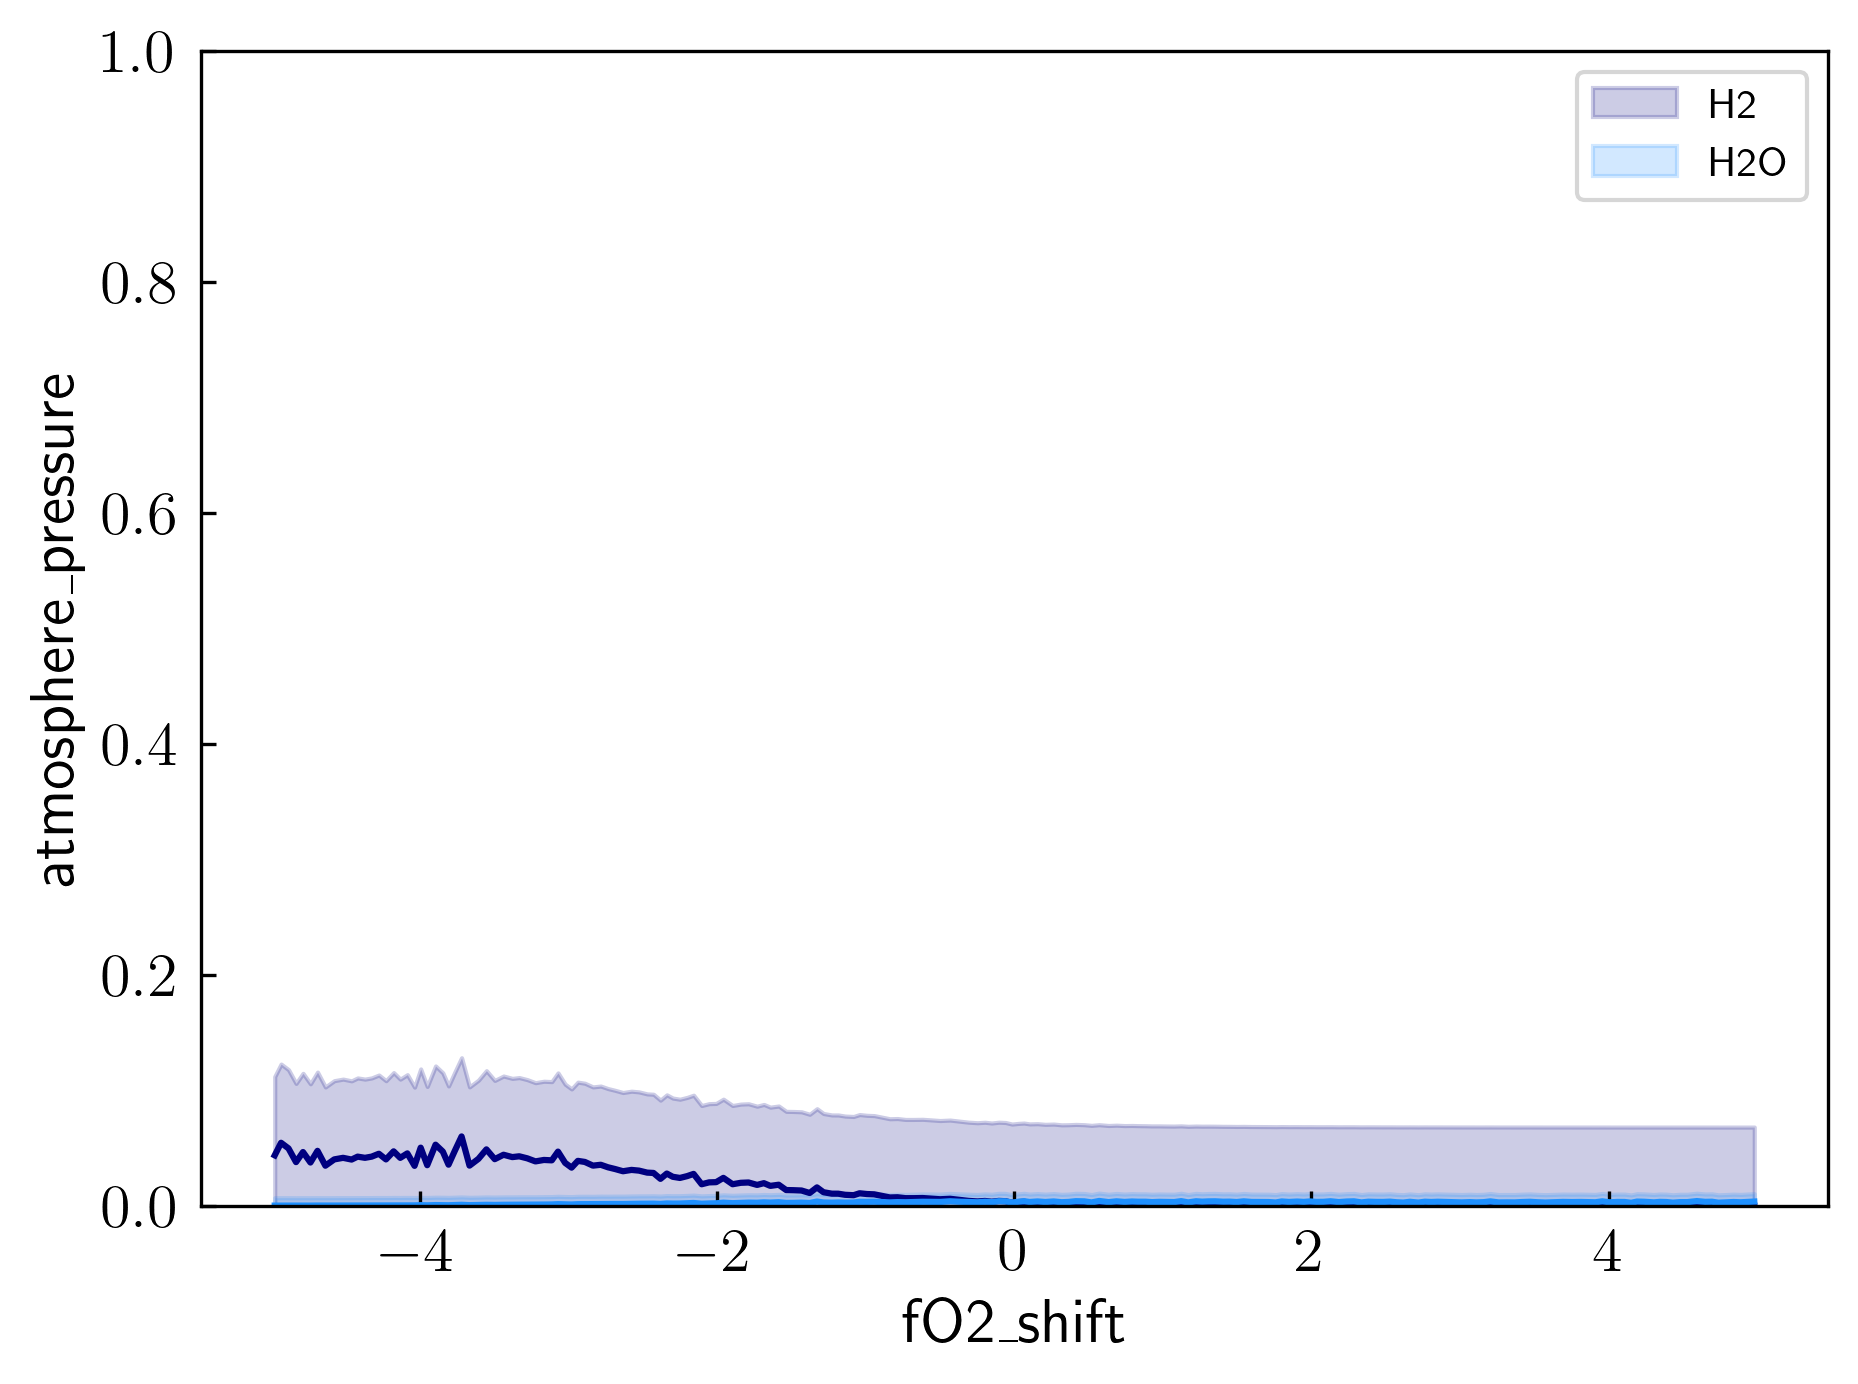

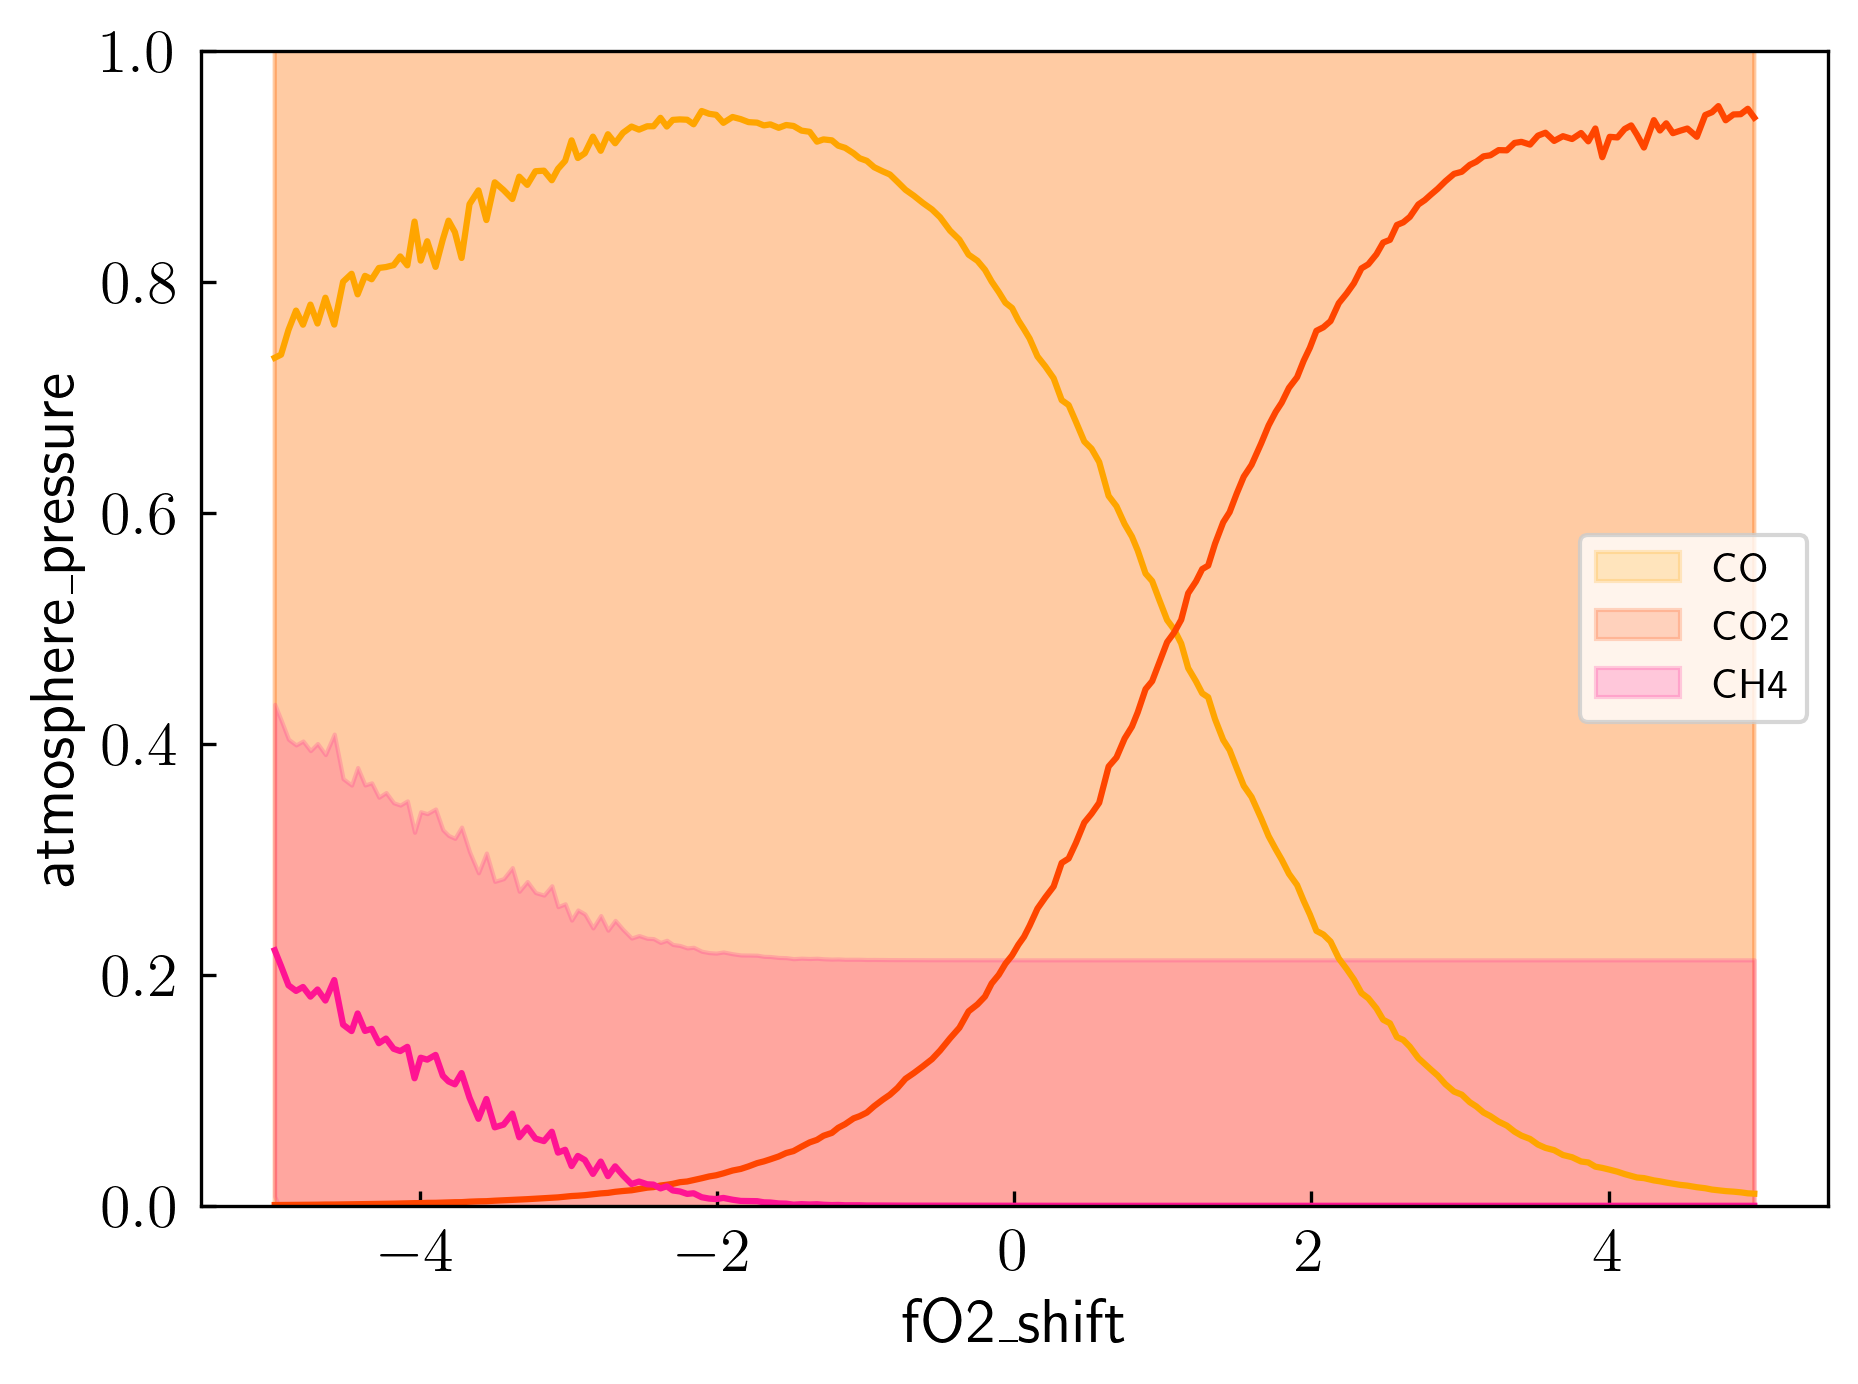

/var/folders/48/rykhh41s6ds_xk4143_5pyv00000gn/T/ipykernel_32382/1500512136.py:30: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(y_min, y_max)


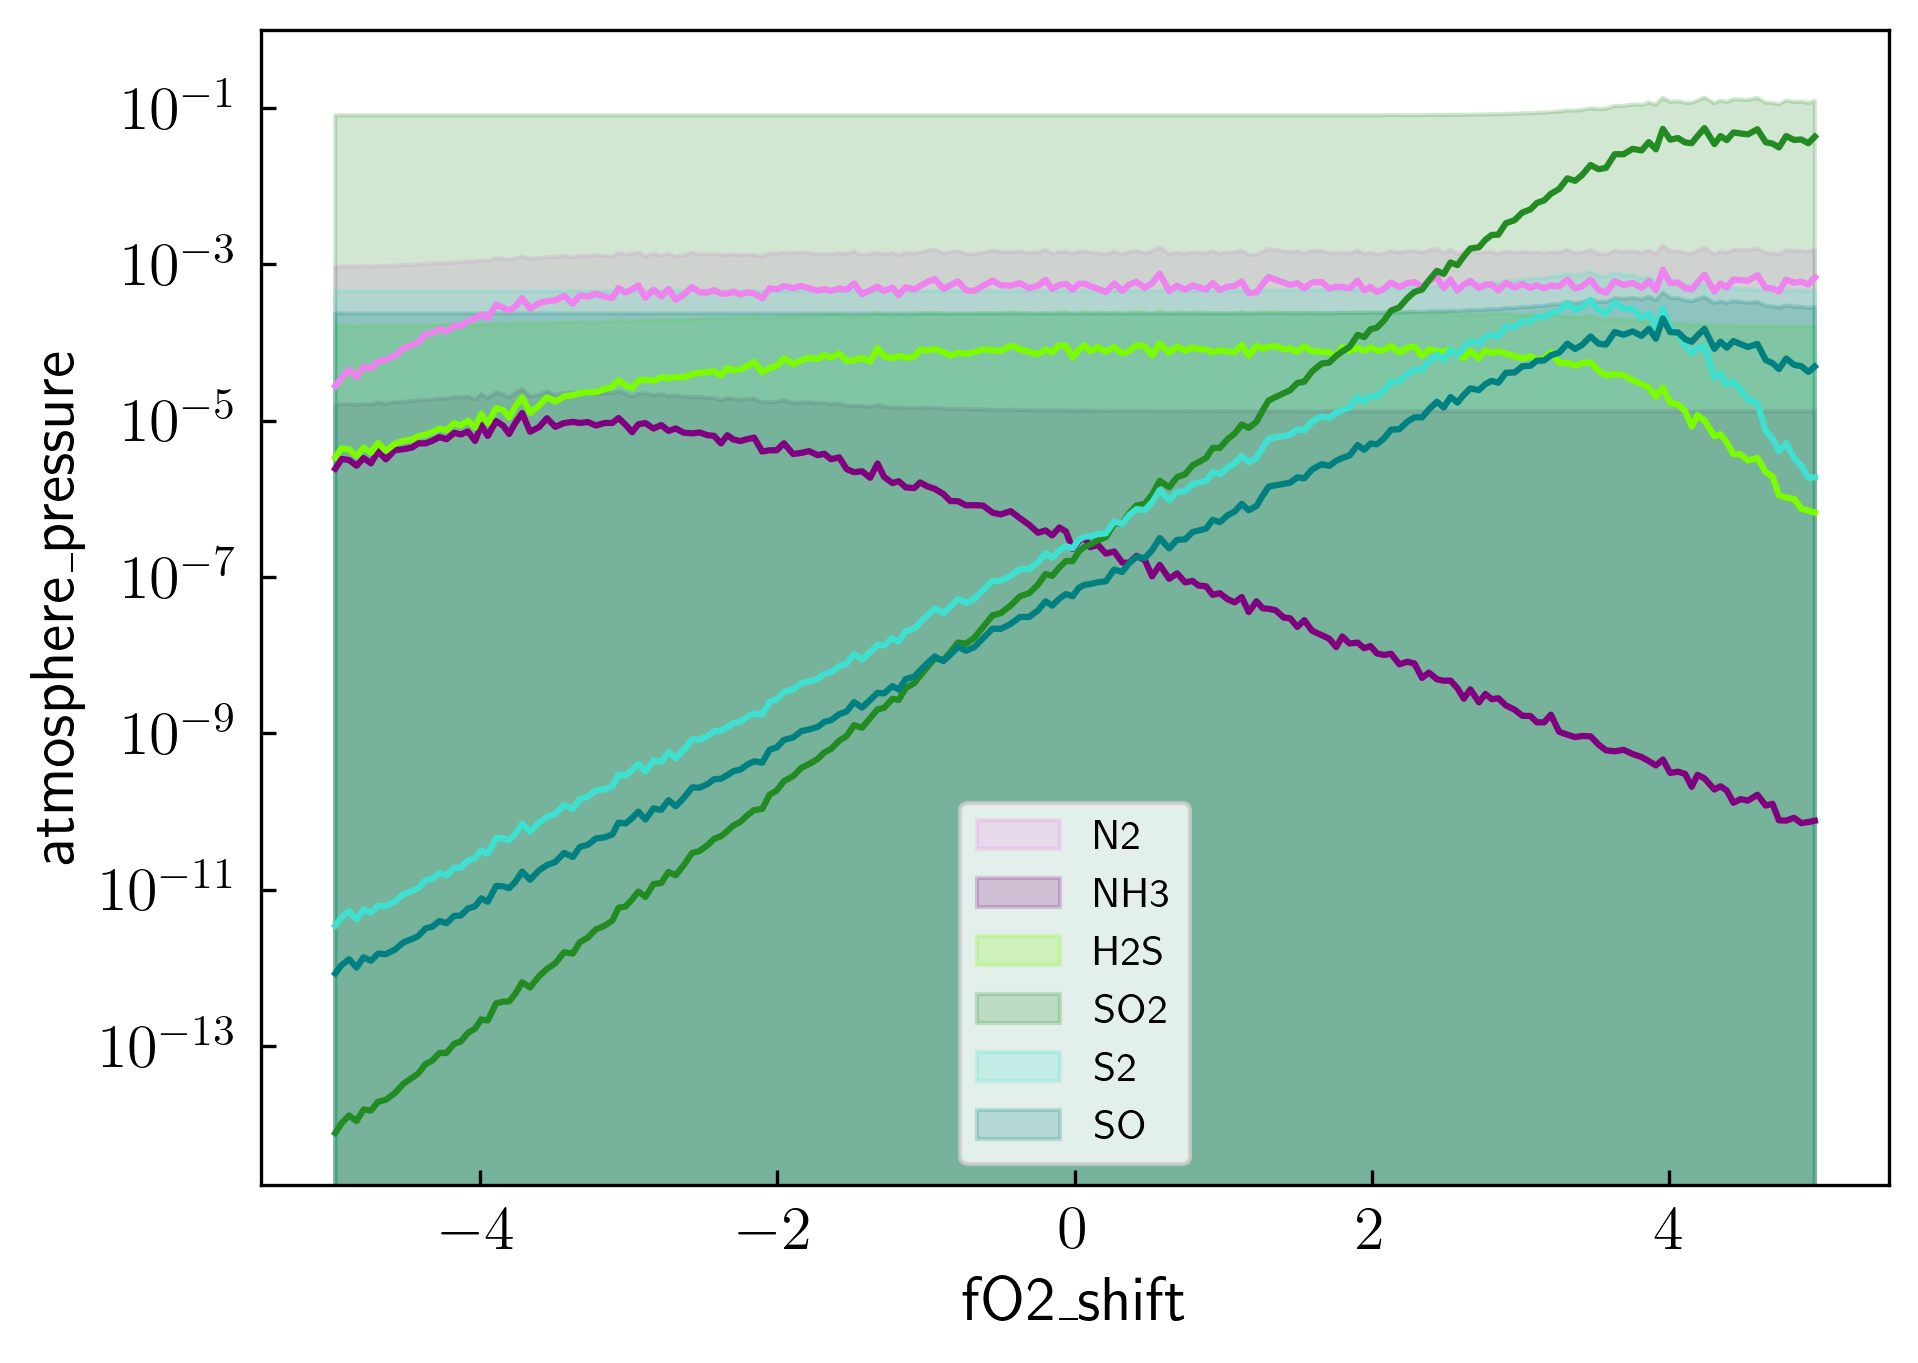

In [19]:
Plot_AvgData_VMR(T1e_with_sols_sort_avg, 'fO2_shift', 'atmosphere_pressure', species[0:2], colors[0:2], 0, 1, 'linear')

Plot_AvgData_VMR(T1e_with_sols_sort_avg, 'fO2_shift', 'atmosphere_pressure', species[2:5], colors[2:5], 0, 1, 'linear')

Plot_AvgData_VMR(T1e_with_sols_sort_avg, 'fO2_shift', 'atmosphere_pressure', species[5:11], colors[5:11], 0, 1, 'log')


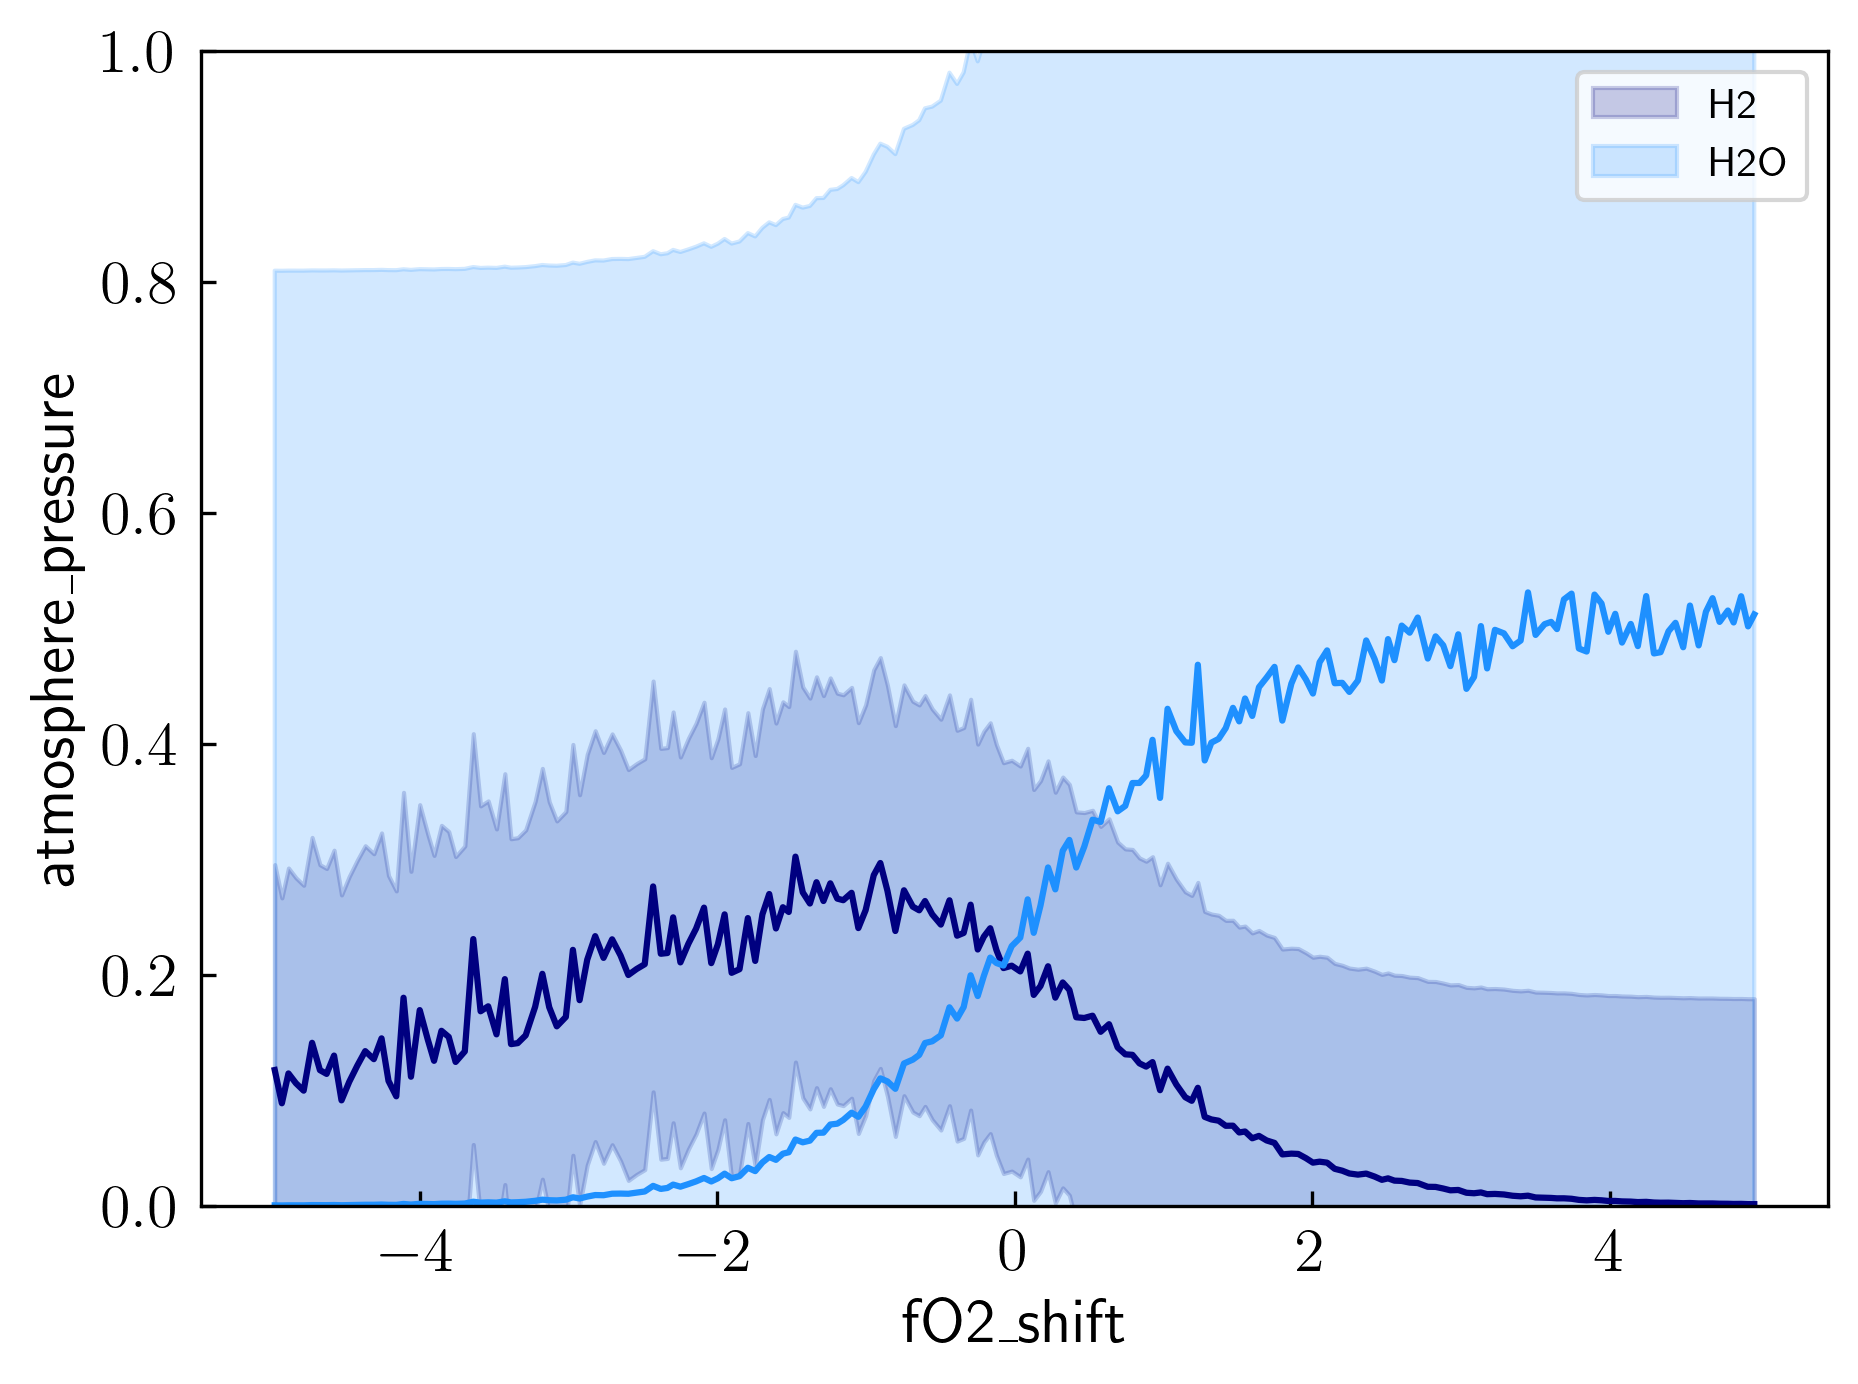

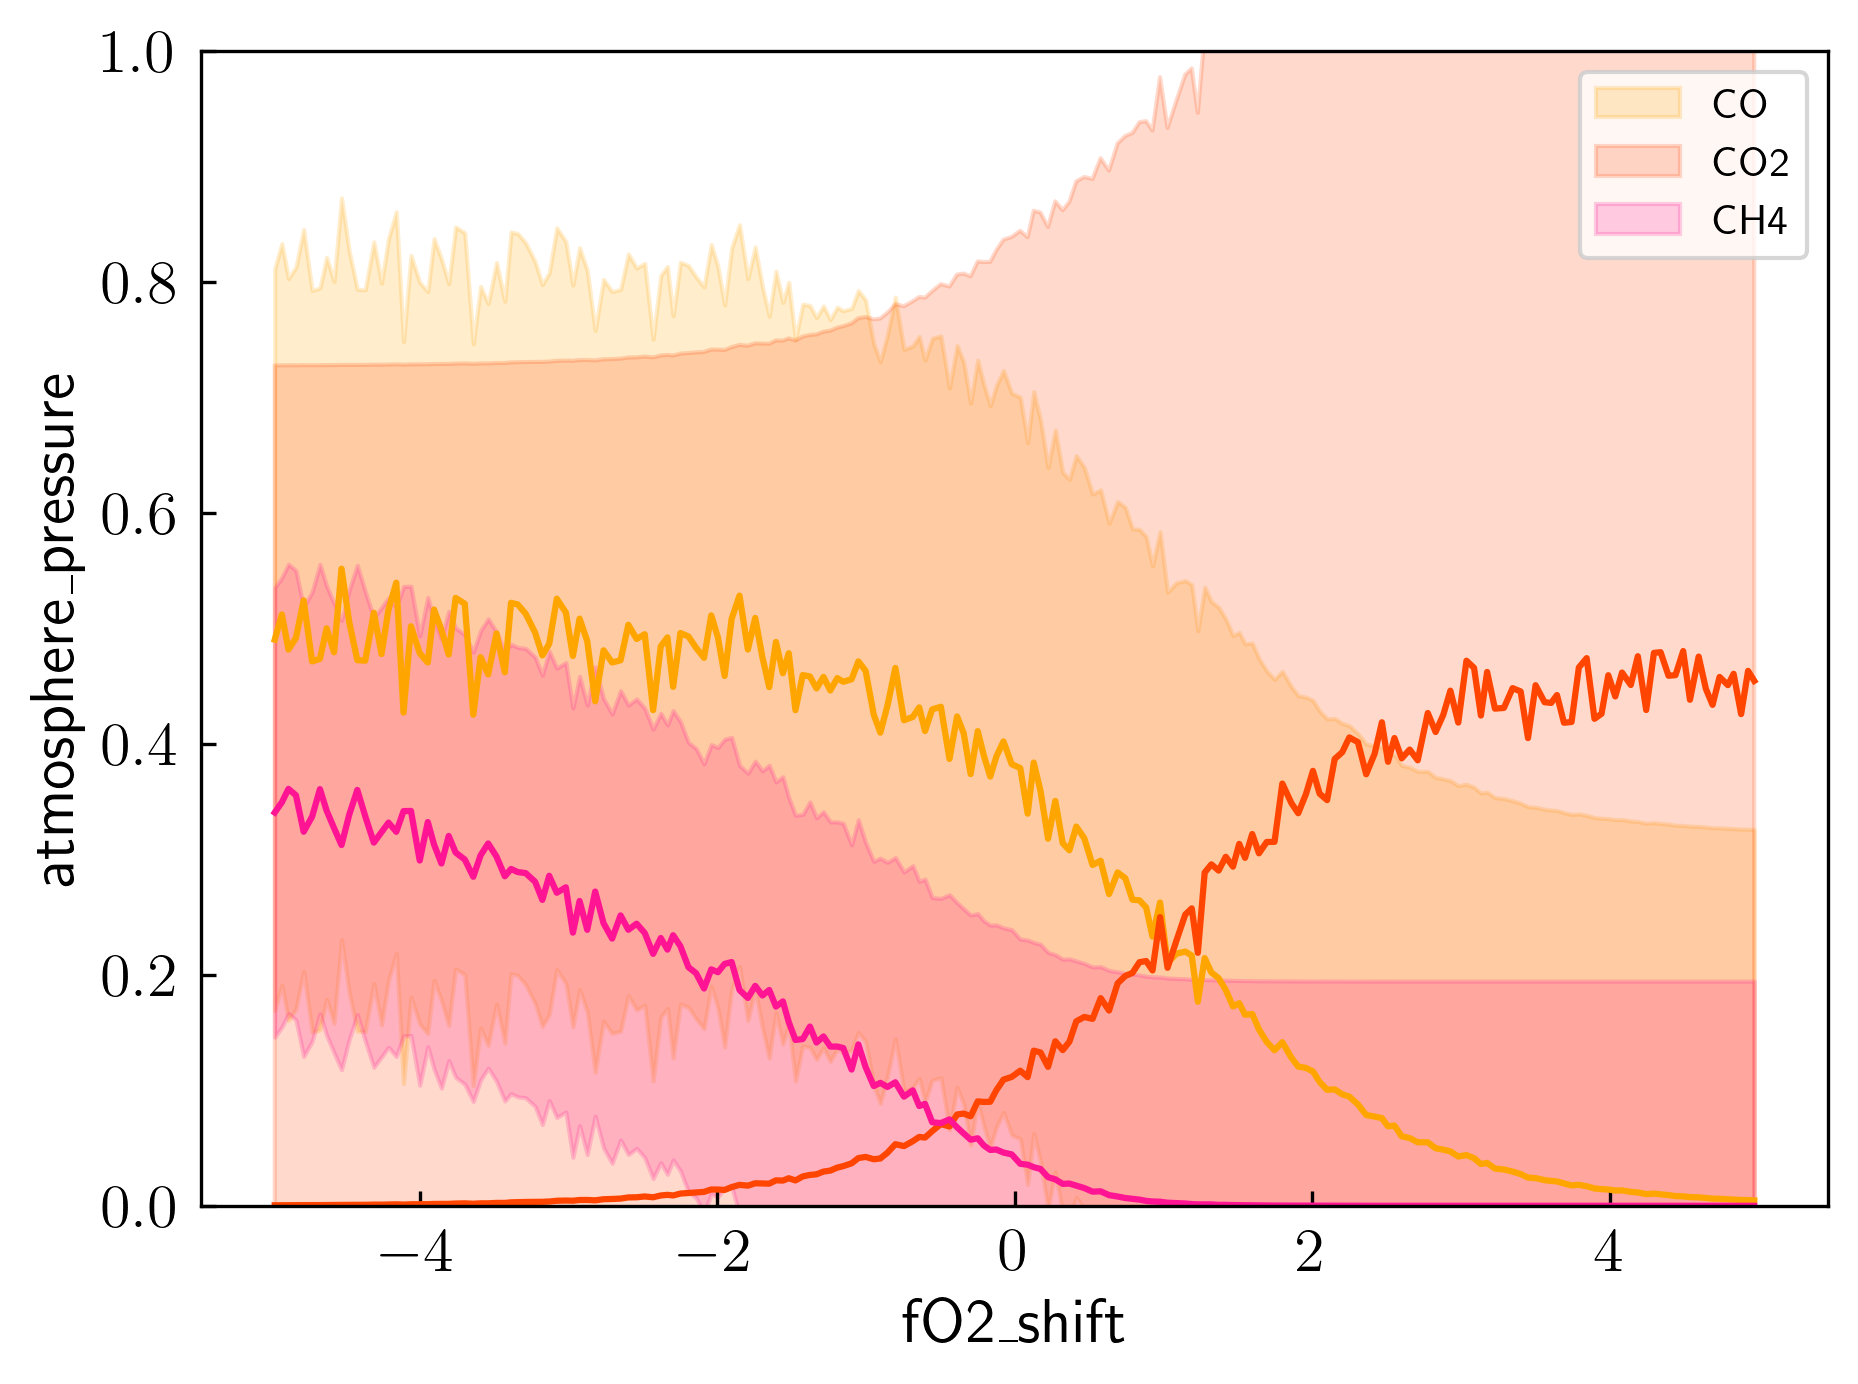

/var/folders/48/rykhh41s6ds_xk4143_5pyv00000gn/T/ipykernel_3661/1500512136.py:30: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(y_min, y_max)


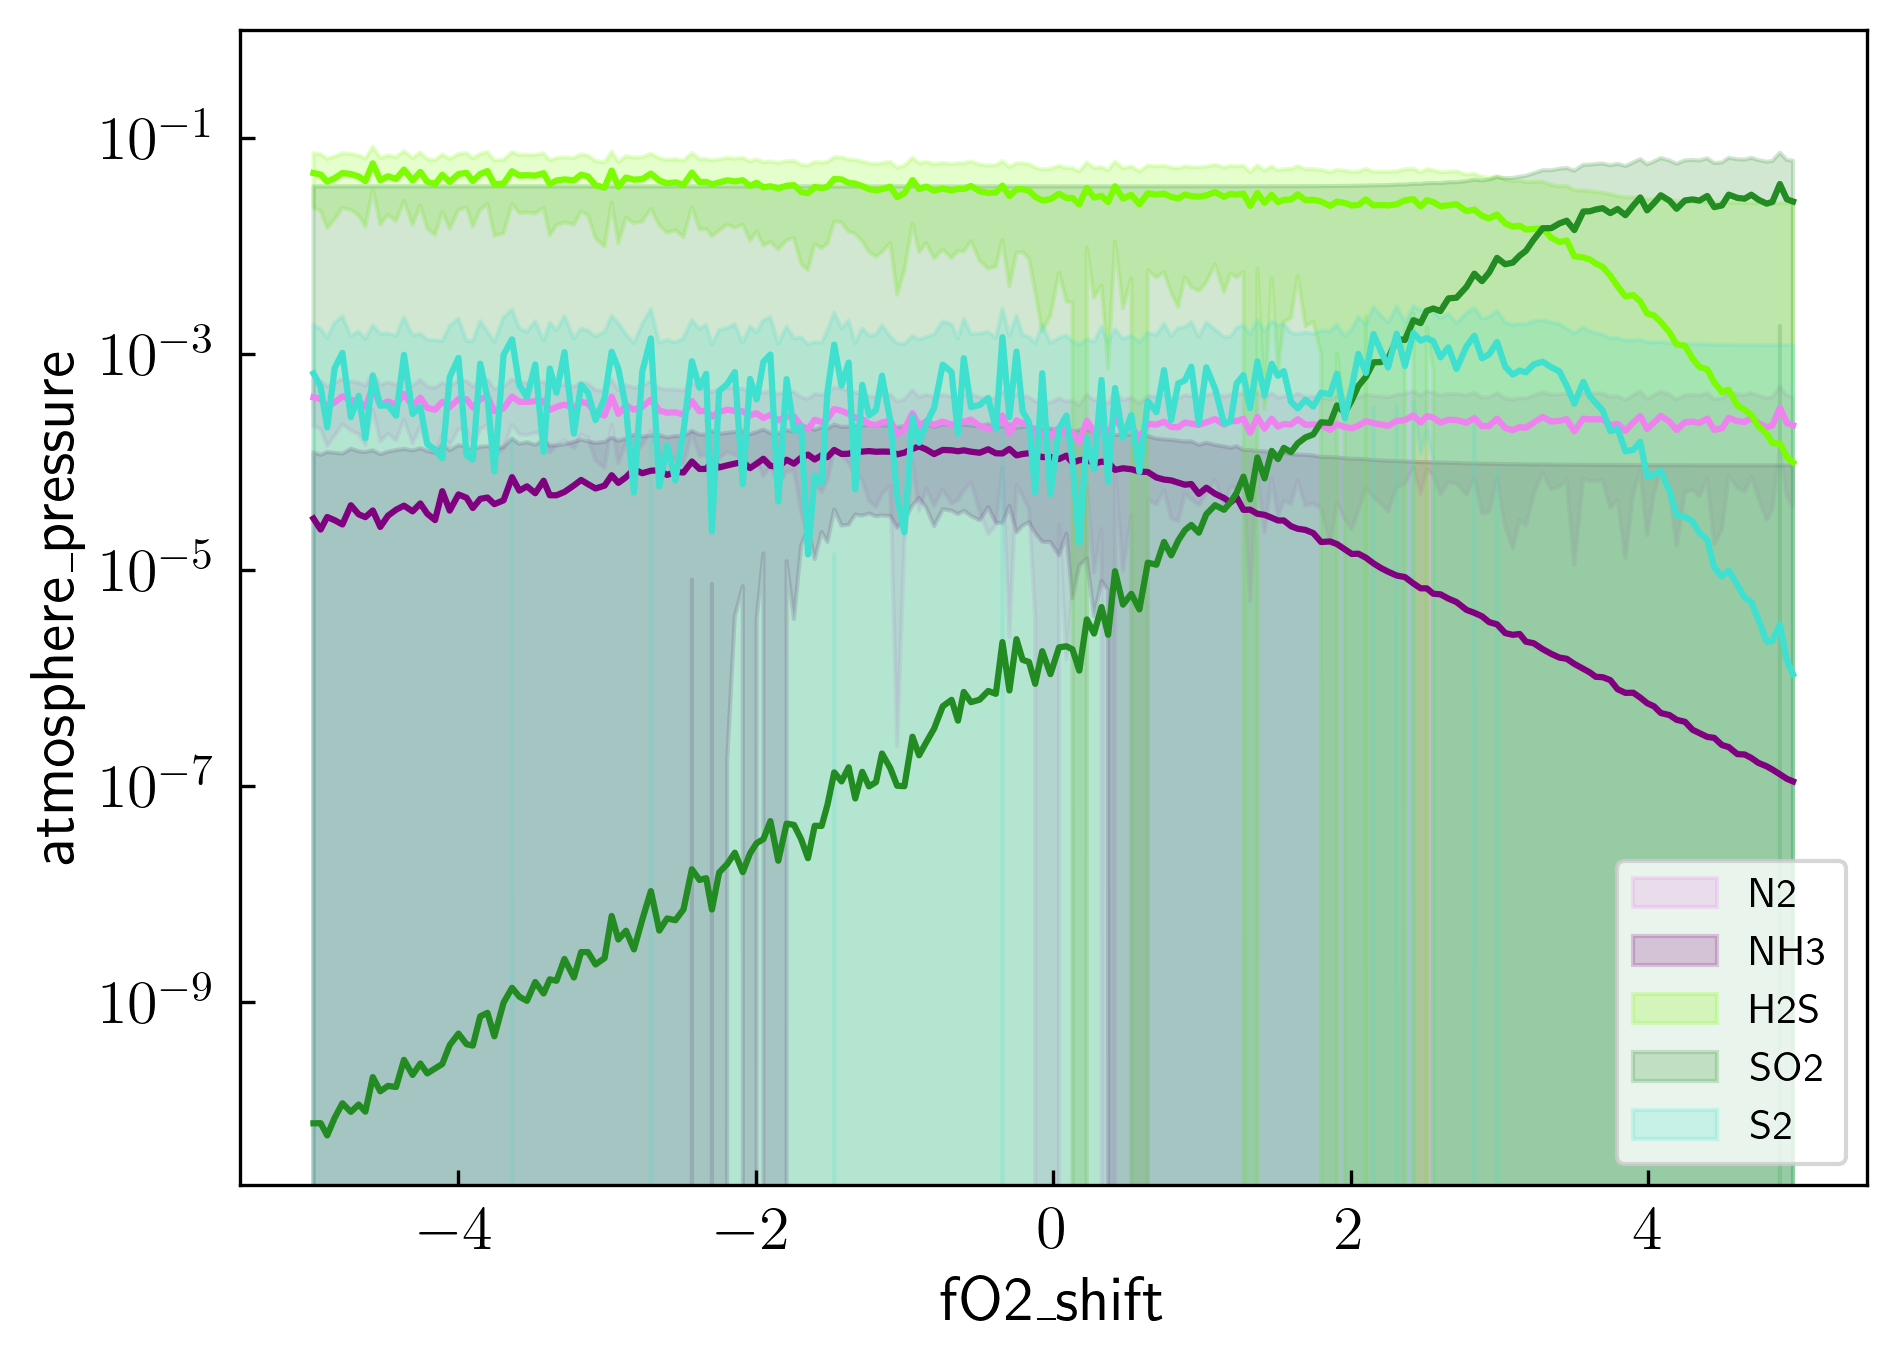

In [77]:
Plot_AvgData_VMR(T1e_no_sols_sort_avg, 'fO2_shift', 'atmosphere_pressure', species[0:2], colors[0:2], 0, 1, 'linear')

Plot_AvgData_VMR(T1e_no_sols_sort_avg, 'fO2_shift', 'atmosphere_pressure', species[2:5], colors[2:5], 0, 1, 'linear')

Plot_AvgData_VMR(T1e_no_sols_sort_avg, 'fO2_shift', 'atmosphere_pressure', species[5:10], colors[5:10], 0, 1, 'log')


## K2-18b 

In [20]:

k218b_ideal_ox = Plotter.read_pickle('DataFiles/k218b_2000K_ideal_with_sols_HCON_earthpropmantle_1000its_oxidized.pkl')
k218b_ideal_ox.dataframes['atmosphere']

k218b_ideal_red = Plotter.read_pickle('DataFiles/k218b_2000K_ideal_with_sols_HCON_earthpropmantle_1000its_reduced.pkl')

k218b_real_ox = Plotter.read_pickle('DataFiles/k218b_2000K_real_with_sols_HCON_earthpropmantle_1000its_oxidized.pkl')
k218b_real_red = Plotter.read_pickle('DataFiles/k218b_2000K_real_with_sols_HCON_earthpropmantle_1000its_reduced.pkl')


[10:01:28 - atmodeller.output              - INFO     ] - Output: Reading data from DataFiles/k218b_2000K_ideal_with_sols_HCON_earthpropmantle_1000its_oxidized.pkl
[10:01:28 - atmodeller.plot                - INFO     ] - Found data for dict_keys(['H2O', 'H2', 'O2', 'CO', 'CO2', 'CH4', 'N2', 'NH3', 'H_totals', 'O_totals', 'C_totals', 'N_totals', 'atmosphere', 'constraints', 'planet', 'residual', 'solution', 'extra'])
[10:01:28 - atmodeller.output              - INFO     ] - Output: Reading data from DataFiles/k218b_2000K_ideal_with_sols_HCON_earthpropmantle_1000its_reduced.pkl
[10:01:28 - atmodeller.plot                - INFO     ] - Found data for dict_keys(['H2O', 'H2', 'O2', 'CO', 'CO2', 'CH4', 'N2', 'NH3', 'O_totals', 'H_totals', 'C_totals', 'N_totals', 'atmosphere', 'constraints', 'planet', 'residual', 'solution', 'extra'])
[10:01:28 - atmodeller.output              - INFO     ] - Output: Reading data from DataFiles/k218b_2000K_real_with_sols_HCON_earthpropmantle_1000its_oxidized.

In [21]:
print(k218b_ideal_red.dataframes['atmosphere'])

         pressure  mean_molar_mass          mass  species_moles  element_moles
0     4497.634338         0.007021  1.262255e+23   1.797834e+25   4.331296e+25
1     6177.160672         0.008436  1.733612e+23   2.054927e+25   5.011472e+25
2    45160.726221         0.014843  1.267430e+24   8.538949e+25   3.585495e+26
3    51809.575261         0.011755  1.454029e+24   1.236895e+26   5.041976e+26
4    12141.645493         0.026971  3.407538e+23   1.263389e+25   2.747674e+25
..            ...              ...           ...            ...            ...
995   3628.246131         0.014585  1.018263e+23   6.981425e+24   2.586587e+25
996  62116.927181         0.017294  1.743304e+24   1.008048e+26   4.509545e+26
997  26019.762591         0.009803  7.302414e+23   7.449534e+25   2.605848e+26
998  42045.145230         0.013883  1.179992e+24   8.499254e+25   3.815135e+26
999   3773.799084         0.025608  1.059112e+23   4.135936e+24   8.893316e+24

[1000 rows x 5 columns]


Text(0.5, 1.0, 'Real')

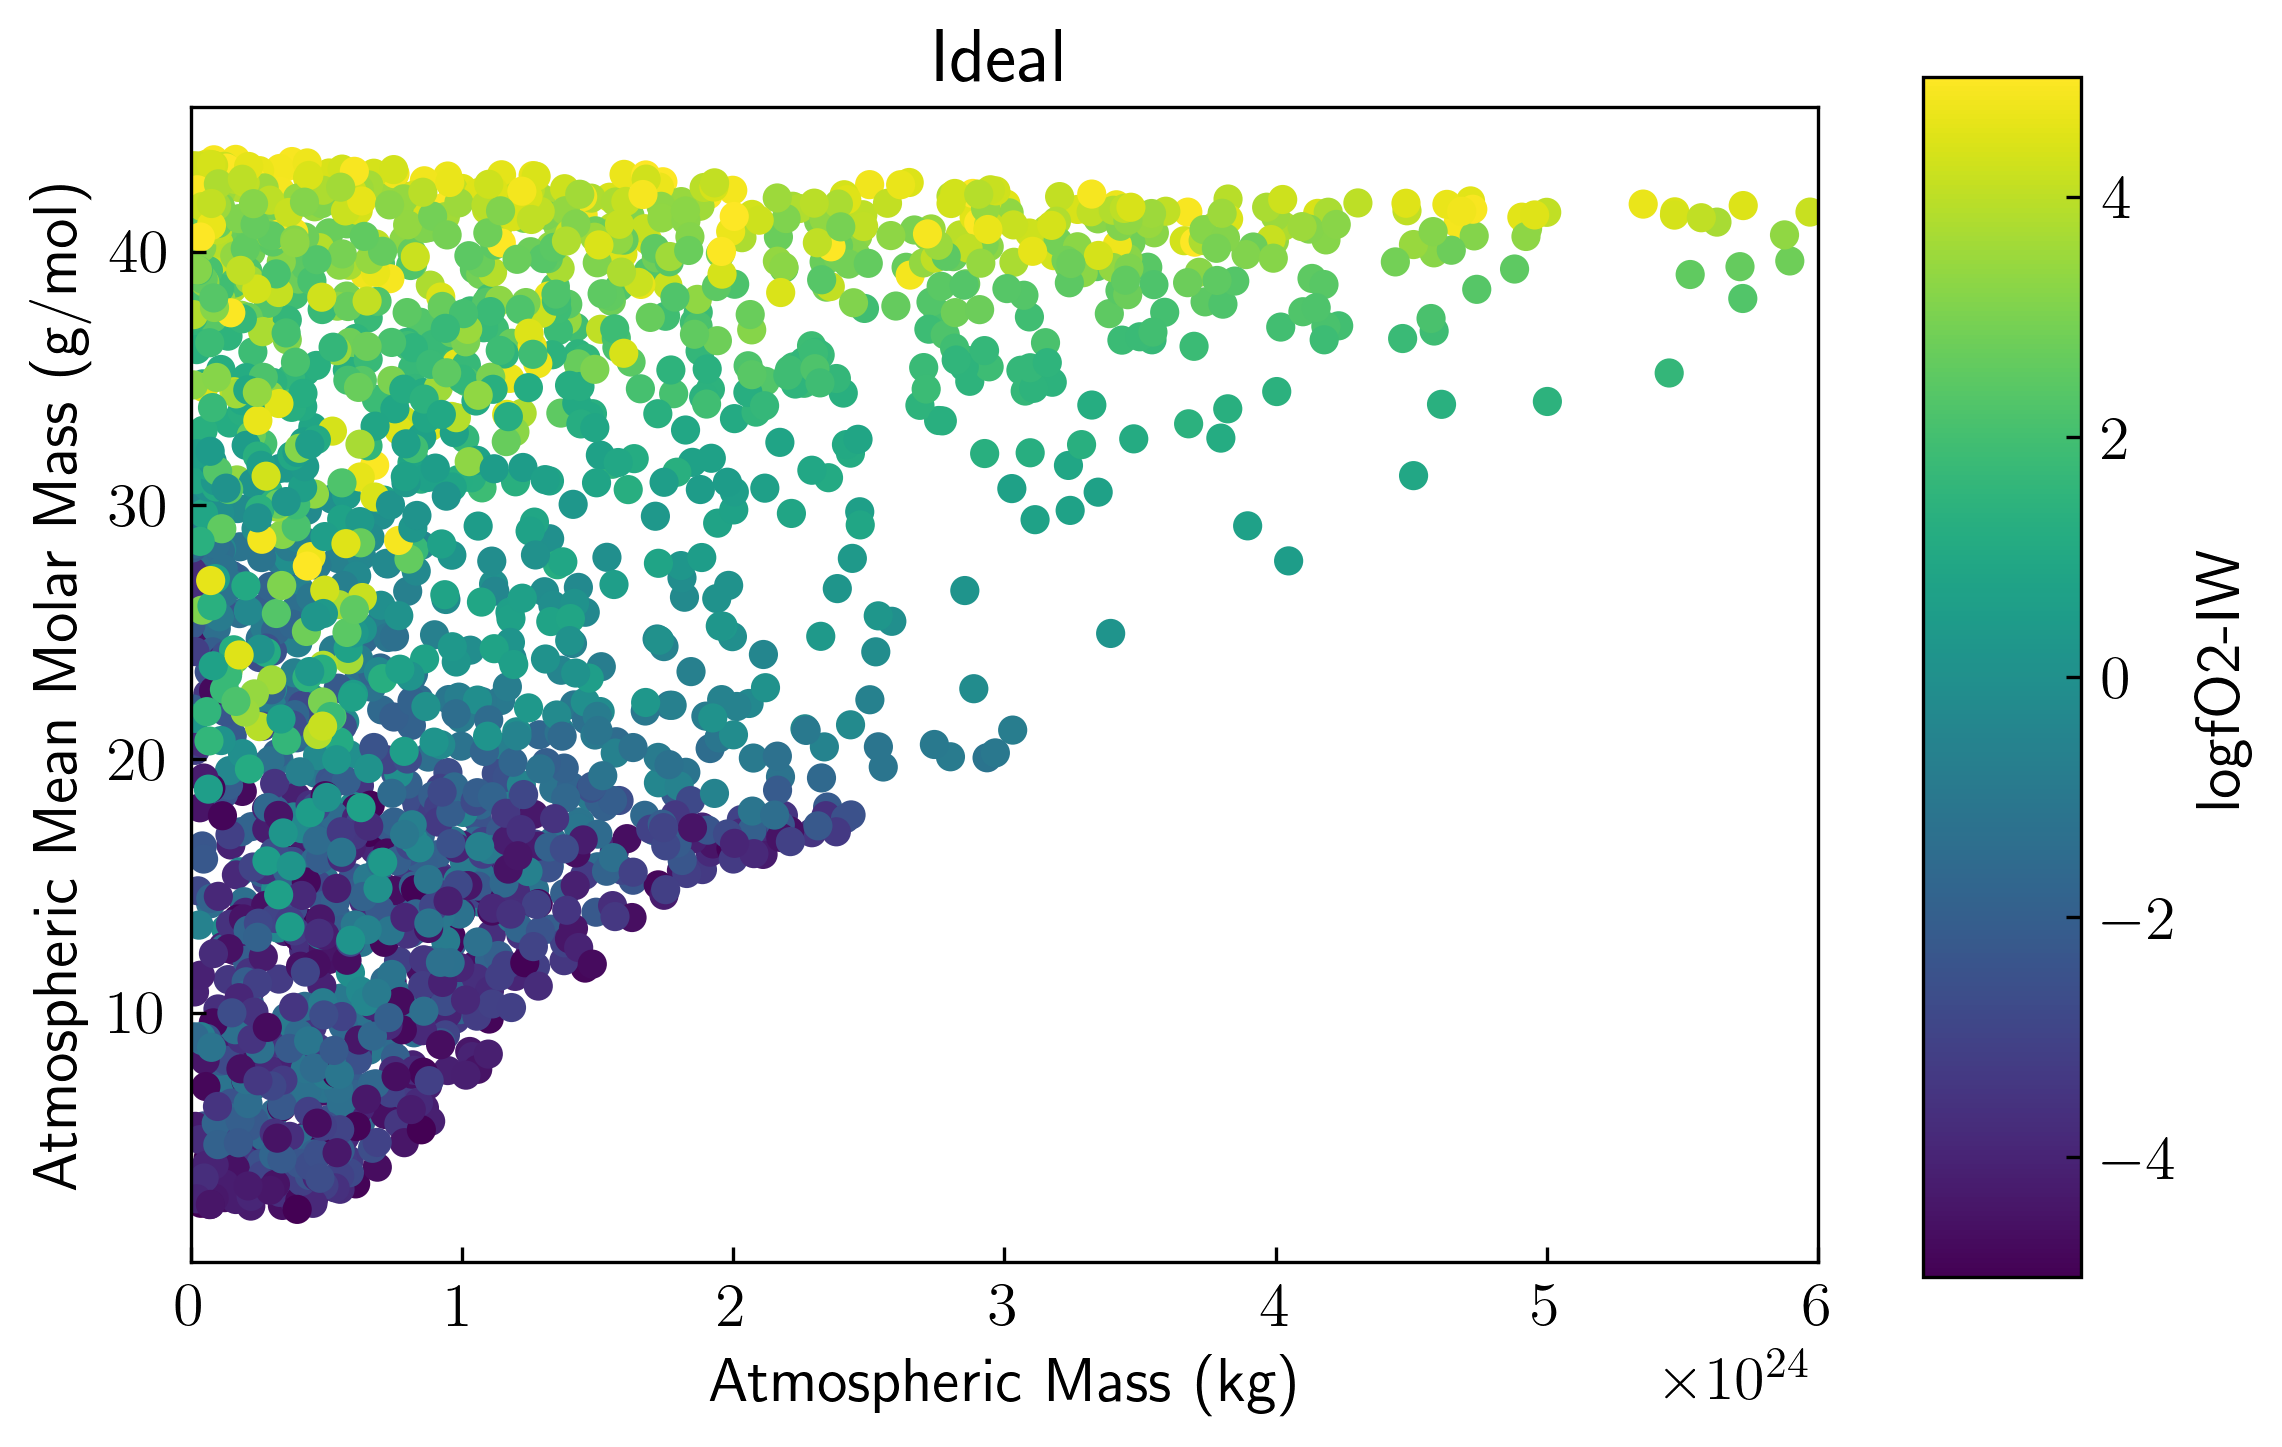

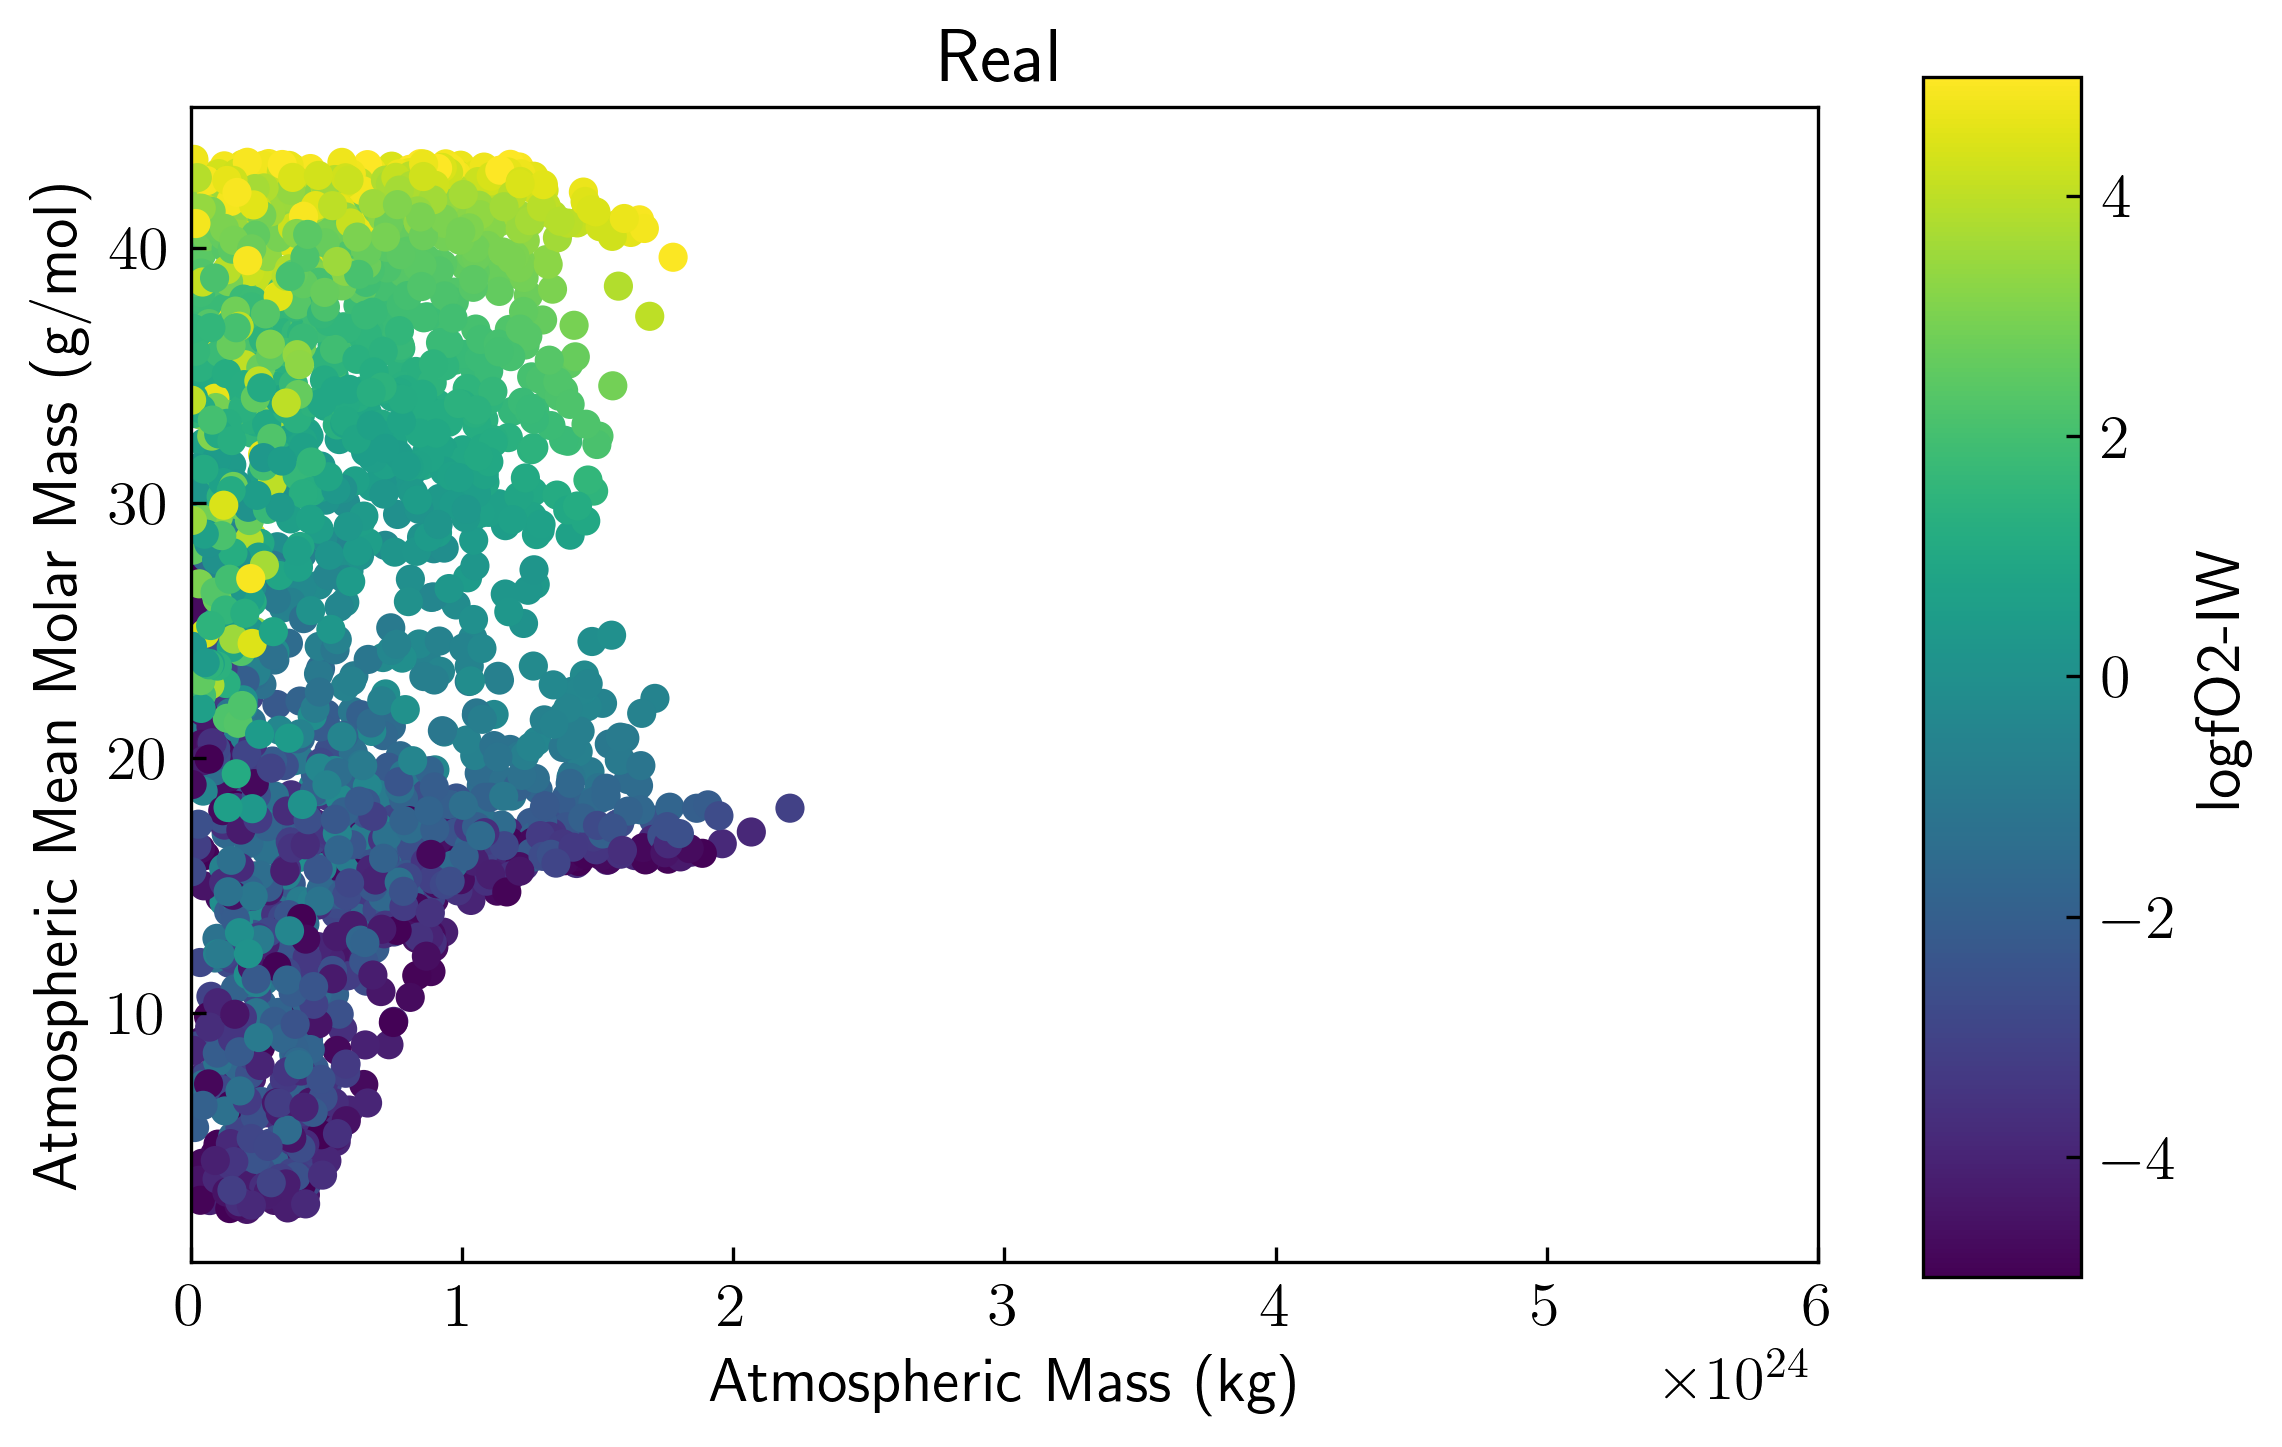

In [22]:
fig, ax = plt.subplots()

#colormap = plt.cm.get_cmap('RdYlGn') # 'plasma' or 'viridis'
colors=pd.concat([k218b_ideal_red.dataframes['extra']['fO2_shift'], k218b_ideal_ox.dataframes['extra']['fO2_shift']])
#H2O-CO2
sc=ax.scatter(pd.concat([k218b_ideal_red.dataframes['atmosphere']['mass'], k218b_ideal_ox.dataframes['atmosphere']['mass']]), pd.concat([k218b_ideal_red.dataframes['atmosphere']['mean_molar_mass']*1000, k218b_ideal_ox.dataframes['atmosphere']['mean_molar_mass']*1000]), c=colors)

#ax.set_xscale('log')
#ax[0,0].set_yscale('log')
ax.set_xlabel('Atmospheric Mass (kg)')
ax.set_ylabel('Atmospheric Mean Molar Mass (g/mol)')
ax.set_xlim(-0.1,6e24)
cbar_ax = fig.add_axes([0.95, 0.1, 0.075, 0.8])
fig.colorbar(sc, cax=cbar_ax, label='logfO2-IW')
ax.set_title('Ideal')

fig, ax = plt.subplots()

#colormap = plt.cm.get_cmap('RdYlGn') # 'plasma' or 'viridis'
colors=pd.concat([k218b_real_red.dataframes['extra']['fO2_shift'], k218b_real_ox.dataframes['extra']['fO2_shift']])
#H2O-CO2
sc=ax.scatter(pd.concat([k218b_real_red.dataframes['atmosphere']['mass'], k218b_real_ox.dataframes['atmosphere']['mass']]), pd.concat([k218b_real_red.dataframes['atmosphere']['mean_molar_mass']*1000, k218b_real_ox.dataframes['atmosphere']['mean_molar_mass']*1000]), c=colors)

#ax.set_xscale('log')
#ax[0,0].set_yscale('log')
ax.set_xlabel('Atmospheric Mass (kg)')
ax.set_ylabel('Atmospheric Mean Molar Mass (g/mol)')
ax.set_xlim(-0.1,6e24)
cbar_ax = fig.add_axes([0.95, 0.1, 0.075, 0.8])
fig.colorbar(sc, cax=cbar_ax, label='logfO2-IW')
ax.set_title('Real')

Text(0.5, 1.0, 'Reduced, Real')

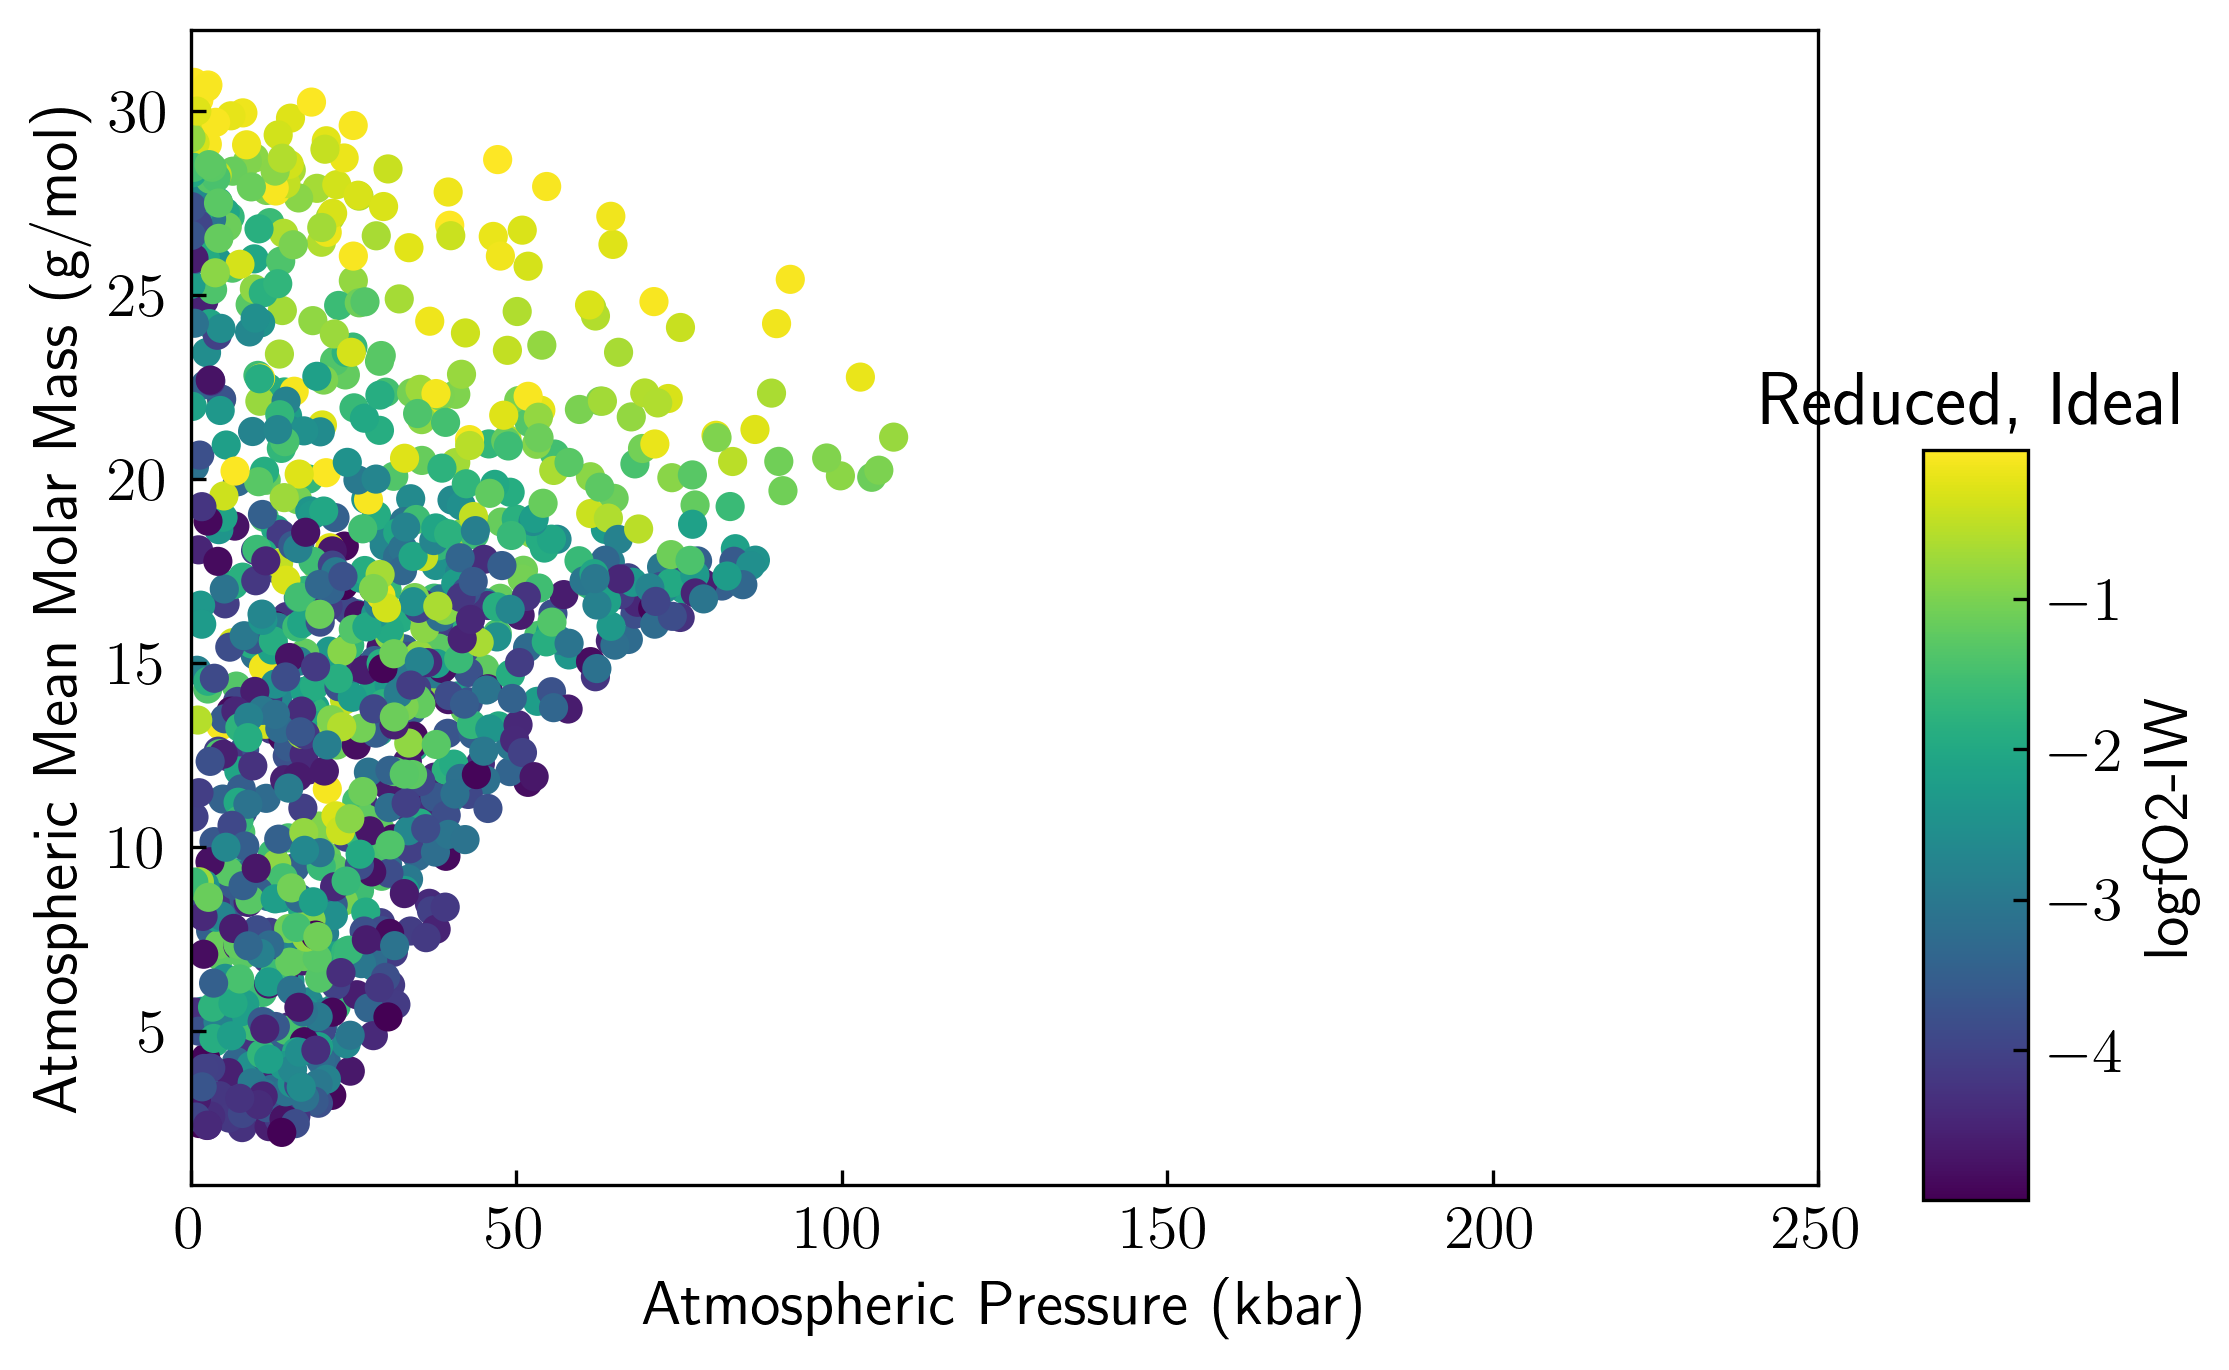

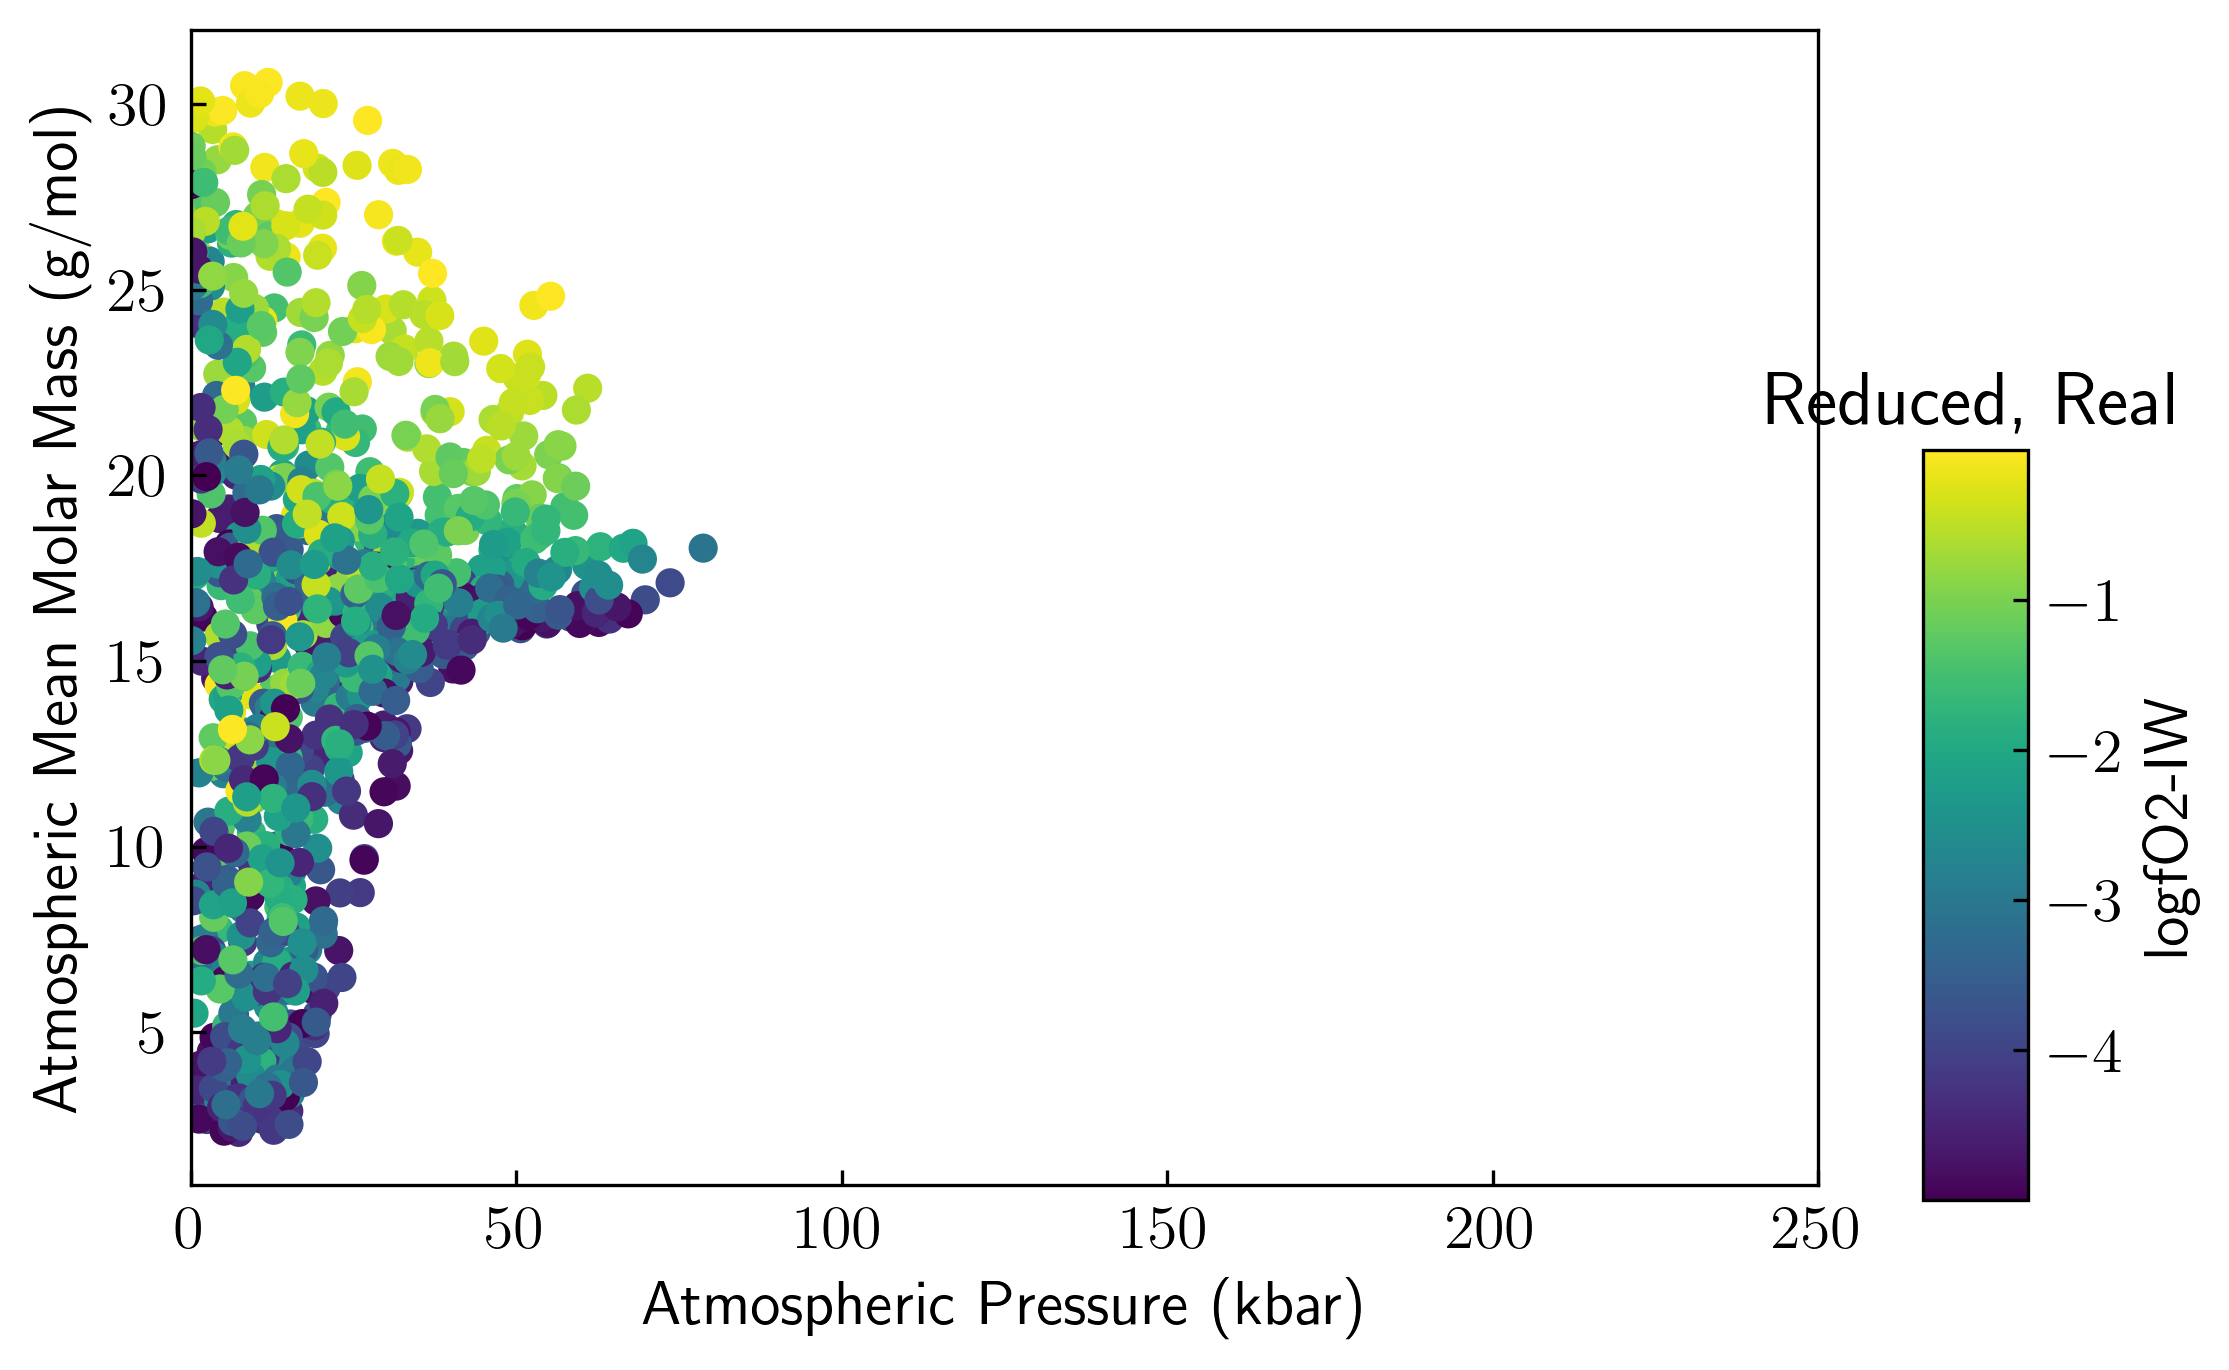

In [103]:
fig, ax = plt.subplots()

#colormap = plt.cm.get_cmap('RdYlGn') # 'plasma' or 'viridis'
colors=k218b_ideal_red.dataframes['extra']['fO2_shift']
#H2O-CO2
sc=ax.scatter(k218b_ideal_red.dataframes['atmosphere']['pressure']/1000, k218b_ideal_red.dataframes['atmosphere']['mean_molar_mass']*1000, c=colors)

#ax.set_xscale('log')
#ax[0,0].set_yscale('log')
ax.set_xlabel('Atmospheric Pressure (kbar)')
ax.set_ylabel('Atmospheric Mean Molar Mass (g/mol)')
ax.set_xlim(0,250)
cbar_ax = fig.add_axes([0.95, 0.10, 0.05, 0.5])
fig.colorbar(sc, cax=cbar_ax, label='logfO2-IW')
plt.title('Reduced, Ideal')

fig, ax = plt.subplots()

#colormap = plt.cm.get_cmap('RdYlGn') # 'plasma' or 'viridis'
colors=k218b_real_red.dataframes['extra']['fO2_shift']
#H2O-CO2
sc=ax.scatter(k218b_real_red.dataframes['atmosphere']['pressure']/1000, k218b_real_red.dataframes['atmosphere']['mean_molar_mass']*1000, c=colors)

#ax.set_xscale('log')
#ax[0,0].set_yscale('log')
ax.set_xlabel('Atmospheric Pressure (kbar)')
ax.set_ylabel('Atmospheric Mean Molar Mass (g/mol)')
ax.set_xlim(0,250)
cbar_ax = fig.add_axes([0.95, 0.10, 0.05, 0.5])
fig.colorbar(sc, cax=cbar_ax, label='logfO2-IW')
plt.title('Reduced, Real')

In [99]:
print(np.min(k218b_real_ox.dataframes['atmosphere']['pressure']/1000))

0.1123304564591503
